# Generative Adversarial Networks (GAN)


This code was taken from Prof. Rowel Atienza's blog:
https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

In [2]:
'''
DCGAN on MNIST using Keras
Author: Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments
Dependencies: tensorflow 1.0 and keras 2.0
Usage: python3 dcgan_mnist.py
'''

import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [4]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

In [5]:
class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",\
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

In [ ]:
mnist_dcgan = MNIST_DCGAN()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7,

38: [D loss: 0.044172, acc: 0.992188]  [A loss: 16.023018, acc: 0.000000]
39: [D loss: 1.604936, acc: 0.525391]  [A loss: 0.000000, acc: 1.000000]
40: [D loss: 3.156106, acc: 0.500000]  [A loss: 0.002289, acc: 1.000000]
41: [D loss: 0.110872, acc: 0.972656]  [A loss: 0.008070, acc: 1.000000]
42: [D loss: 0.089052, acc: 0.982422]  [A loss: 0.037608, acc: 0.992188]
43: [D loss: 0.129177, acc: 0.964844]  [A loss: 0.051766, acc: 0.984375]
44: [D loss: 0.174999, acc: 0.935547]  [A loss: 0.072837, acc: 0.976562]
45: [D loss: 0.325797, acc: 0.837891]  [A loss: 0.807220, acc: 0.671875]
46: [D loss: 1.774097, acc: 0.511719]  [A loss: 1.233510, acc: 0.394531]
47: [D loss: 1.169326, acc: 0.546875]  [A loss: 1.268454, acc: 0.351562]
48: [D loss: 1.089915, acc: 0.546875]  [A loss: 3.411747, acc: 0.011719]
49: [D loss: 0.734727, acc: 0.632812]  [A loss: 2.324482, acc: 0.042969]
50: [D loss: 0.801343, acc: 0.601562]  [A loss: 4.432120, acc: 0.000000]
51: [D loss: 0.462407, acc: 0.751953]  [A loss: 2.

150: [D loss: 0.606987, acc: 0.535156]  [A loss: 1.854363, acc: 0.000000]
151: [D loss: 0.519515, acc: 0.845703]  [A loss: 0.712465, acc: 0.449219]
152: [D loss: 0.720957, acc: 0.501953]  [A loss: 1.885725, acc: 0.000000]
153: [D loss: 0.558103, acc: 0.769531]  [A loss: 0.684345, acc: 0.535156]
154: [D loss: 0.678767, acc: 0.505859]  [A loss: 1.422484, acc: 0.000000]
155: [D loss: 0.545226, acc: 0.812500]  [A loss: 0.855374, acc: 0.187500]
156: [D loss: 0.623102, acc: 0.519531]  [A loss: 1.412106, acc: 0.000000]
157: [D loss: 0.521699, acc: 0.843750]  [A loss: 0.929596, acc: 0.144531]
158: [D loss: 0.606416, acc: 0.550781]  [A loss: 1.535324, acc: 0.000000]
159: [D loss: 0.514734, acc: 0.853516]  [A loss: 0.784118, acc: 0.296875]
160: [D loss: 0.657621, acc: 0.513672]  [A loss: 1.729472, acc: 0.000000]
161: [D loss: 0.553618, acc: 0.783203]  [A loss: 0.670769, acc: 0.554688]
162: [D loss: 0.683770, acc: 0.507812]  [A loss: 1.563834, acc: 0.000000]
163: [D loss: 0.574821, acc: 0.775391]

261: [D loss: 0.608934, acc: 0.687500]  [A loss: 0.837577, acc: 0.234375]
262: [D loss: 0.636665, acc: 0.591797]  [A loss: 1.393553, acc: 0.000000]
263: [D loss: 0.596367, acc: 0.730469]  [A loss: 0.777054, acc: 0.386719]
264: [D loss: 0.714010, acc: 0.517578]  [A loss: 1.673192, acc: 0.000000]
265: [D loss: 0.606903, acc: 0.687500]  [A loss: 0.662206, acc: 0.582031]
266: [D loss: 0.748671, acc: 0.507812]  [A loss: 1.511749, acc: 0.000000]
267: [D loss: 0.616222, acc: 0.656250]  [A loss: 0.713653, acc: 0.472656]
268: [D loss: 0.696092, acc: 0.500000]  [A loss: 1.252690, acc: 0.000000]
269: [D loss: 0.608930, acc: 0.685547]  [A loss: 0.900806, acc: 0.179688]
270: [D loss: 0.656634, acc: 0.550781]  [A loss: 1.194982, acc: 0.007812]
271: [D loss: 0.618912, acc: 0.673828]  [A loss: 0.905822, acc: 0.128906]
272: [D loss: 0.627196, acc: 0.566406]  [A loss: 1.267558, acc: 0.007812]
273: [D loss: 0.615728, acc: 0.671875]  [A loss: 1.136079, acc: 0.019531]
274: [D loss: 0.629990, acc: 0.613281]

372: [D loss: 0.687968, acc: 0.507812]  [A loss: 0.991365, acc: 0.035156]
373: [D loss: 0.666039, acc: 0.603516]  [A loss: 0.753445, acc: 0.300781]
374: [D loss: 0.694304, acc: 0.515625]  [A loss: 1.040523, acc: 0.011719]
375: [D loss: 0.649463, acc: 0.646484]  [A loss: 0.828861, acc: 0.171875]
376: [D loss: 0.675554, acc: 0.548828]  [A loss: 1.066135, acc: 0.023438]
377: [D loss: 0.664619, acc: 0.623047]  [A loss: 0.843017, acc: 0.148438]
378: [D loss: 0.678156, acc: 0.564453]  [A loss: 1.020088, acc: 0.023438]
379: [D loss: 0.676994, acc: 0.542969]  [A loss: 0.938394, acc: 0.093750]
380: [D loss: 0.675083, acc: 0.593750]  [A loss: 0.959245, acc: 0.046875]
381: [D loss: 0.665181, acc: 0.595703]  [A loss: 0.995702, acc: 0.066406]
382: [D loss: 0.663127, acc: 0.601562]  [A loss: 0.955988, acc: 0.058594]
383: [D loss: 0.679248, acc: 0.558594]  [A loss: 1.048737, acc: 0.031250]
384: [D loss: 0.662383, acc: 0.605469]  [A loss: 0.911199, acc: 0.097656]
385: [D loss: 0.670882, acc: 0.583984]

483: [D loss: 0.658852, acc: 0.636719]  [A loss: 0.767089, acc: 0.359375]
484: [D loss: 0.686282, acc: 0.554688]  [A loss: 1.086565, acc: 0.007812]
485: [D loss: 0.656372, acc: 0.619141]  [A loss: 0.732208, acc: 0.460938]
486: [D loss: 0.698031, acc: 0.533203]  [A loss: 1.148402, acc: 0.011719]
487: [D loss: 0.660110, acc: 0.605469]  [A loss: 0.732401, acc: 0.390625]
488: [D loss: 0.702465, acc: 0.531250]  [A loss: 1.100013, acc: 0.042969]
489: [D loss: 0.667073, acc: 0.593750]  [A loss: 0.744666, acc: 0.410156]
490: [D loss: 0.683818, acc: 0.548828]  [A loss: 1.060230, acc: 0.039062]
491: [D loss: 0.664724, acc: 0.599609]  [A loss: 0.789887, acc: 0.265625]
492: [D loss: 0.687472, acc: 0.546875]  [A loss: 0.976497, acc: 0.050781]
493: [D loss: 0.667468, acc: 0.593750]  [A loss: 0.832959, acc: 0.226562]
494: [D loss: 0.668040, acc: 0.564453]  [A loss: 1.003789, acc: 0.035156]
495: [D loss: 0.666460, acc: 0.607422]  [A loss: 0.880362, acc: 0.132812]
496: [D loss: 0.669194, acc: 0.615234]

594: [D loss: 0.650035, acc: 0.615234]  [A loss: 0.803042, acc: 0.304688]
595: [D loss: 0.680758, acc: 0.556641]  [A loss: 1.048916, acc: 0.039062]
596: [D loss: 0.664537, acc: 0.570312]  [A loss: 0.859878, acc: 0.222656]
597: [D loss: 0.674013, acc: 0.550781]  [A loss: 1.031009, acc: 0.066406]
598: [D loss: 0.673237, acc: 0.597656]  [A loss: 0.756850, acc: 0.343750]
599: [D loss: 0.679669, acc: 0.556641]  [A loss: 1.109478, acc: 0.027344]
600: [D loss: 0.654300, acc: 0.619141]  [A loss: 0.785553, acc: 0.355469]
601: [D loss: 0.671324, acc: 0.570312]  [A loss: 1.163060, acc: 0.062500]
602: [D loss: 0.682069, acc: 0.578125]  [A loss: 0.808791, acc: 0.292969]
603: [D loss: 0.682423, acc: 0.554688]  [A loss: 1.025773, acc: 0.074219]
604: [D loss: 0.655365, acc: 0.603516]  [A loss: 0.805021, acc: 0.324219]
605: [D loss: 0.657765, acc: 0.583984]  [A loss: 1.055162, acc: 0.042969]
606: [D loss: 0.661414, acc: 0.583984]  [A loss: 0.806230, acc: 0.304688]
607: [D loss: 0.670766, acc: 0.582031]

705: [D loss: 0.698585, acc: 0.556641]  [A loss: 1.155674, acc: 0.019531]
706: [D loss: 0.671988, acc: 0.587891]  [A loss: 0.809238, acc: 0.312500]
707: [D loss: 0.669164, acc: 0.556641]  [A loss: 1.062827, acc: 0.078125]
708: [D loss: 0.639123, acc: 0.652344]  [A loss: 0.814376, acc: 0.273438]
709: [D loss: 0.715342, acc: 0.529297]  [A loss: 1.204060, acc: 0.015625]
710: [D loss: 0.680676, acc: 0.564453]  [A loss: 0.690549, acc: 0.546875]
711: [D loss: 0.718686, acc: 0.521484]  [A loss: 1.232727, acc: 0.019531]
712: [D loss: 0.660130, acc: 0.566406]  [A loss: 0.719890, acc: 0.460938]
713: [D loss: 0.711370, acc: 0.521484]  [A loss: 1.059149, acc: 0.042969]
714: [D loss: 0.656877, acc: 0.607422]  [A loss: 0.822908, acc: 0.257812]
715: [D loss: 0.690591, acc: 0.539062]  [A loss: 0.964969, acc: 0.078125]
716: [D loss: 0.659448, acc: 0.583984]  [A loss: 0.868003, acc: 0.234375]
717: [D loss: 0.667053, acc: 0.615234]  [A loss: 1.000680, acc: 0.074219]
718: [D loss: 0.666153, acc: 0.605469]

816: [D loss: 0.672353, acc: 0.591797]  [A loss: 0.707102, acc: 0.488281]
817: [D loss: 0.708698, acc: 0.542969]  [A loss: 1.131845, acc: 0.035156]
818: [D loss: 0.670415, acc: 0.580078]  [A loss: 0.723990, acc: 0.476562]
819: [D loss: 0.699996, acc: 0.560547]  [A loss: 1.050029, acc: 0.046875]
820: [D loss: 0.678774, acc: 0.589844]  [A loss: 0.784756, acc: 0.351562]
821: [D loss: 0.677369, acc: 0.556641]  [A loss: 1.001732, acc: 0.058594]
822: [D loss: 0.668275, acc: 0.580078]  [A loss: 0.880888, acc: 0.210938]
823: [D loss: 0.691265, acc: 0.560547]  [A loss: 1.077138, acc: 0.054688]
824: [D loss: 0.671163, acc: 0.562500]  [A loss: 0.848286, acc: 0.269531]
825: [D loss: 0.676650, acc: 0.578125]  [A loss: 0.975949, acc: 0.082031]
826: [D loss: 0.661053, acc: 0.593750]  [A loss: 0.922494, acc: 0.140625]
827: [D loss: 0.670257, acc: 0.582031]  [A loss: 0.880322, acc: 0.167969]
828: [D loss: 0.688503, acc: 0.566406]  [A loss: 1.037310, acc: 0.066406]
829: [D loss: 0.677286, acc: 0.562500]

927: [D loss: 0.676303, acc: 0.560547]  [A loss: 0.919984, acc: 0.140625]
928: [D loss: 0.655732, acc: 0.632812]  [A loss: 0.899033, acc: 0.160156]
929: [D loss: 0.690401, acc: 0.531250]  [A loss: 0.959422, acc: 0.113281]
930: [D loss: 0.679545, acc: 0.556641]  [A loss: 0.891229, acc: 0.167969]
931: [D loss: 0.675945, acc: 0.585938]  [A loss: 0.956902, acc: 0.117188]
932: [D loss: 0.677721, acc: 0.578125]  [A loss: 0.892555, acc: 0.160156]
933: [D loss: 0.679236, acc: 0.560547]  [A loss: 0.974784, acc: 0.128906]
934: [D loss: 0.671180, acc: 0.564453]  [A loss: 0.876588, acc: 0.246094]
935: [D loss: 0.686138, acc: 0.580078]  [A loss: 1.063371, acc: 0.058594]
936: [D loss: 0.689557, acc: 0.541016]  [A loss: 0.758071, acc: 0.398438]
937: [D loss: 0.709123, acc: 0.541016]  [A loss: 1.127275, acc: 0.031250]
938: [D loss: 0.662915, acc: 0.603516]  [A loss: 0.748902, acc: 0.433594]
939: [D loss: 0.711846, acc: 0.529297]  [A loss: 1.102776, acc: 0.039062]
940: [D loss: 0.663642, acc: 0.597656]

1038: [D loss: 0.680898, acc: 0.568359]  [A loss: 0.908285, acc: 0.167969]
1039: [D loss: 0.669787, acc: 0.570312]  [A loss: 0.986663, acc: 0.113281]
1040: [D loss: 0.669099, acc: 0.593750]  [A loss: 0.818712, acc: 0.289062]
1041: [D loss: 0.681702, acc: 0.542969]  [A loss: 1.084134, acc: 0.042969]
1042: [D loss: 0.682329, acc: 0.562500]  [A loss: 0.652072, acc: 0.613281]
1043: [D loss: 0.720448, acc: 0.533203]  [A loss: 1.209198, acc: 0.027344]
1044: [D loss: 0.732179, acc: 0.505859]  [A loss: 0.723126, acc: 0.460938]
1045: [D loss: 0.724065, acc: 0.486328]  [A loss: 1.071585, acc: 0.035156]
1046: [D loss: 0.668916, acc: 0.591797]  [A loss: 0.765946, acc: 0.367188]
1047: [D loss: 0.703394, acc: 0.527344]  [A loss: 1.022067, acc: 0.070312]
1048: [D loss: 0.670460, acc: 0.587891]  [A loss: 0.793045, acc: 0.320312]
1049: [D loss: 0.691375, acc: 0.544922]  [A loss: 0.962607, acc: 0.109375]
1050: [D loss: 0.660098, acc: 0.601562]  [A loss: 0.837286, acc: 0.238281]
1051: [D loss: 0.687938, 

1148: [D loss: 0.677262, acc: 0.580078]  [A loss: 0.948576, acc: 0.152344]
1149: [D loss: 0.663397, acc: 0.605469]  [A loss: 0.926073, acc: 0.175781]
1150: [D loss: 0.685465, acc: 0.558594]  [A loss: 0.980801, acc: 0.117188]
1151: [D loss: 0.677233, acc: 0.578125]  [A loss: 0.810125, acc: 0.312500]
1152: [D loss: 0.731866, acc: 0.535156]  [A loss: 1.158299, acc: 0.027344]
1153: [D loss: 0.686508, acc: 0.552734]  [A loss: 0.683809, acc: 0.527344]
1154: [D loss: 0.728071, acc: 0.527344]  [A loss: 1.037324, acc: 0.062500]
1155: [D loss: 0.669870, acc: 0.605469]  [A loss: 0.710275, acc: 0.480469]
1156: [D loss: 0.691789, acc: 0.542969]  [A loss: 1.017067, acc: 0.062500]
1157: [D loss: 0.675454, acc: 0.597656]  [A loss: 0.767316, acc: 0.417969]
1158: [D loss: 0.701371, acc: 0.562500]  [A loss: 1.002971, acc: 0.113281]
1159: [D loss: 0.682565, acc: 0.558594]  [A loss: 0.795909, acc: 0.335938]
1160: [D loss: 0.693253, acc: 0.570312]  [A loss: 1.003139, acc: 0.109375]
1161: [D loss: 0.686428, 

1258: [D loss: 0.695061, acc: 0.535156]  [A loss: 1.043301, acc: 0.089844]
1259: [D loss: 0.683098, acc: 0.560547]  [A loss: 0.742326, acc: 0.398438]
1260: [D loss: 0.697402, acc: 0.542969]  [A loss: 1.044162, acc: 0.074219]
1261: [D loss: 0.683622, acc: 0.564453]  [A loss: 0.748123, acc: 0.425781]
1262: [D loss: 0.727013, acc: 0.509766]  [A loss: 0.985551, acc: 0.101562]
1263: [D loss: 0.677828, acc: 0.576172]  [A loss: 0.809432, acc: 0.308594]
1264: [D loss: 0.684396, acc: 0.583984]  [A loss: 1.020291, acc: 0.093750]
1265: [D loss: 0.684423, acc: 0.527344]  [A loss: 0.874666, acc: 0.218750]
1266: [D loss: 0.702072, acc: 0.533203]  [A loss: 0.907071, acc: 0.214844]
1267: [D loss: 0.682801, acc: 0.564453]  [A loss: 0.895385, acc: 0.199219]
1268: [D loss: 0.671014, acc: 0.591797]  [A loss: 0.919264, acc: 0.187500]
1269: [D loss: 0.672788, acc: 0.576172]  [A loss: 0.919289, acc: 0.183594]
1270: [D loss: 0.685005, acc: 0.560547]  [A loss: 0.895023, acc: 0.164062]
1271: [D loss: 0.673721, 

1368: [D loss: 0.689538, acc: 0.562500]  [A loss: 0.947177, acc: 0.160156]
1369: [D loss: 0.705868, acc: 0.501953]  [A loss: 0.849297, acc: 0.269531]
1370: [D loss: 0.683353, acc: 0.570312]  [A loss: 0.986010, acc: 0.089844]
1371: [D loss: 0.676241, acc: 0.574219]  [A loss: 0.819579, acc: 0.316406]
1372: [D loss: 0.686029, acc: 0.556641]  [A loss: 0.977724, acc: 0.105469]
1373: [D loss: 0.693053, acc: 0.576172]  [A loss: 0.872023, acc: 0.226562]
1374: [D loss: 0.689373, acc: 0.519531]  [A loss: 1.012916, acc: 0.113281]
1375: [D loss: 0.672938, acc: 0.568359]  [A loss: 0.751458, acc: 0.414062]
1376: [D loss: 0.699539, acc: 0.539062]  [A loss: 1.088280, acc: 0.042969]
1377: [D loss: 0.680416, acc: 0.564453]  [A loss: 0.709094, acc: 0.527344]
1378: [D loss: 0.698876, acc: 0.533203]  [A loss: 1.139952, acc: 0.027344]
1379: [D loss: 0.682503, acc: 0.566406]  [A loss: 0.741797, acc: 0.449219]
1380: [D loss: 0.690469, acc: 0.548828]  [A loss: 1.036638, acc: 0.082031]
1381: [D loss: 0.690860, 

1478: [D loss: 0.705774, acc: 0.511719]  [A loss: 1.017768, acc: 0.097656]
1479: [D loss: 0.694561, acc: 0.529297]  [A loss: 0.758492, acc: 0.402344]
1480: [D loss: 0.689360, acc: 0.550781]  [A loss: 1.038210, acc: 0.054688]
1481: [D loss: 0.678921, acc: 0.580078]  [A loss: 0.742181, acc: 0.453125]
1482: [D loss: 0.697412, acc: 0.550781]  [A loss: 1.063184, acc: 0.062500]
1483: [D loss: 0.688914, acc: 0.533203]  [A loss: 0.719396, acc: 0.492188]
1484: [D loss: 0.715926, acc: 0.527344]  [A loss: 1.078807, acc: 0.054688]
1485: [D loss: 0.686119, acc: 0.556641]  [A loss: 0.688399, acc: 0.546875]
1486: [D loss: 0.713099, acc: 0.509766]  [A loss: 1.011567, acc: 0.093750]
1487: [D loss: 0.677457, acc: 0.585938]  [A loss: 0.776183, acc: 0.335938]
1488: [D loss: 0.701586, acc: 0.548828]  [A loss: 1.005439, acc: 0.082031]
1489: [D loss: 0.672890, acc: 0.580078]  [A loss: 0.813773, acc: 0.304688]
1490: [D loss: 0.695468, acc: 0.517578]  [A loss: 0.983089, acc: 0.136719]
1491: [D loss: 0.676149, 

1588: [D loss: 0.700773, acc: 0.546875]  [A loss: 0.774711, acc: 0.402344]
1589: [D loss: 0.692560, acc: 0.539062]  [A loss: 0.992939, acc: 0.101562]
1590: [D loss: 0.680517, acc: 0.572266]  [A loss: 0.763233, acc: 0.390625]
1591: [D loss: 0.686260, acc: 0.570312]  [A loss: 1.062634, acc: 0.066406]
1592: [D loss: 0.676667, acc: 0.570312]  [A loss: 0.778942, acc: 0.417969]
1593: [D loss: 0.732246, acc: 0.494141]  [A loss: 1.174648, acc: 0.027344]
1594: [D loss: 0.680285, acc: 0.560547]  [A loss: 0.668715, acc: 0.582031]
1595: [D loss: 0.724001, acc: 0.513672]  [A loss: 1.087871, acc: 0.066406]
1596: [D loss: 0.685574, acc: 0.554688]  [A loss: 0.730722, acc: 0.445312]
1597: [D loss: 0.698580, acc: 0.554688]  [A loss: 0.929799, acc: 0.125000]
1598: [D loss: 0.685626, acc: 0.576172]  [A loss: 0.823471, acc: 0.289062]
1599: [D loss: 0.688949, acc: 0.531250]  [A loss: 0.884658, acc: 0.195312]
1600: [D loss: 0.691781, acc: 0.525391]  [A loss: 0.873790, acc: 0.242188]
1601: [D loss: 0.680254, 

1698: [D loss: 0.699410, acc: 0.544922]  [A loss: 0.794757, acc: 0.328125]
1699: [D loss: 0.684581, acc: 0.558594]  [A loss: 0.956882, acc: 0.101562]
1700: [D loss: 0.700489, acc: 0.523438]  [A loss: 0.810771, acc: 0.261719]
1701: [D loss: 0.702424, acc: 0.531250]  [A loss: 0.926379, acc: 0.117188]
1702: [D loss: 0.684564, acc: 0.529297]  [A loss: 0.871944, acc: 0.218750]
1703: [D loss: 0.677691, acc: 0.558594]  [A loss: 0.860159, acc: 0.183594]
1704: [D loss: 0.691503, acc: 0.556641]  [A loss: 0.929524, acc: 0.136719]
1705: [D loss: 0.688020, acc: 0.537109]  [A loss: 0.877148, acc: 0.214844]
1706: [D loss: 0.693698, acc: 0.572266]  [A loss: 0.852761, acc: 0.253906]
1707: [D loss: 0.716327, acc: 0.482422]  [A loss: 1.011962, acc: 0.105469]
1708: [D loss: 0.693707, acc: 0.554688]  [A loss: 0.765242, acc: 0.367188]
1709: [D loss: 0.694182, acc: 0.546875]  [A loss: 1.021356, acc: 0.066406]
1710: [D loss: 0.671564, acc: 0.582031]  [A loss: 0.741627, acc: 0.433594]
1711: [D loss: 0.701580, 

1808: [D loss: 0.689155, acc: 0.521484]  [A loss: 0.885344, acc: 0.160156]
1809: [D loss: 0.695686, acc: 0.560547]  [A loss: 0.851442, acc: 0.246094]
1810: [D loss: 0.700998, acc: 0.519531]  [A loss: 0.954740, acc: 0.093750]
1811: [D loss: 0.691971, acc: 0.552734]  [A loss: 0.744088, acc: 0.433594]
1812: [D loss: 0.697749, acc: 0.544922]  [A loss: 1.003314, acc: 0.058594]
1813: [D loss: 0.698342, acc: 0.541016]  [A loss: 0.692793, acc: 0.539062]
1814: [D loss: 0.700006, acc: 0.541016]  [A loss: 1.053913, acc: 0.054688]
1815: [D loss: 0.687225, acc: 0.535156]  [A loss: 0.717728, acc: 0.480469]
1816: [D loss: 0.702430, acc: 0.523438]  [A loss: 0.978172, acc: 0.101562]
1817: [D loss: 0.685904, acc: 0.537109]  [A loss: 0.734565, acc: 0.410156]
1818: [D loss: 0.690546, acc: 0.531250]  [A loss: 0.879808, acc: 0.160156]
1819: [D loss: 0.682163, acc: 0.558594]  [A loss: 0.810512, acc: 0.281250]
1820: [D loss: 0.694470, acc: 0.513672]  [A loss: 0.896191, acc: 0.160156]
1821: [D loss: 0.675053, 

1918: [D loss: 0.701839, acc: 0.539062]  [A loss: 0.919716, acc: 0.132812]
1919: [D loss: 0.690712, acc: 0.560547]  [A loss: 0.779064, acc: 0.320312]
1920: [D loss: 0.691887, acc: 0.554688]  [A loss: 0.946467, acc: 0.113281]
1921: [D loss: 0.686093, acc: 0.564453]  [A loss: 0.747646, acc: 0.410156]
1922: [D loss: 0.708502, acc: 0.533203]  [A loss: 0.955015, acc: 0.085938]
1923: [D loss: 0.682732, acc: 0.566406]  [A loss: 0.730219, acc: 0.425781]
1924: [D loss: 0.708408, acc: 0.509766]  [A loss: 0.948259, acc: 0.097656]
1925: [D loss: 0.687291, acc: 0.558594]  [A loss: 0.724379, acc: 0.425781]
1926: [D loss: 0.701374, acc: 0.513672]  [A loss: 0.918019, acc: 0.125000]
1927: [D loss: 0.682733, acc: 0.568359]  [A loss: 0.739523, acc: 0.417969]
1928: [D loss: 0.707087, acc: 0.533203]  [A loss: 0.929023, acc: 0.097656]
1929: [D loss: 0.681147, acc: 0.552734]  [A loss: 0.751940, acc: 0.371094]
1930: [D loss: 0.689101, acc: 0.587891]  [A loss: 0.870989, acc: 0.179688]
1931: [D loss: 0.690335, 

2028: [D loss: 0.704944, acc: 0.513672]  [A loss: 0.883206, acc: 0.164062]
2029: [D loss: 0.691914, acc: 0.554688]  [A loss: 0.824495, acc: 0.246094]
2030: [D loss: 0.684524, acc: 0.537109]  [A loss: 0.869902, acc: 0.210938]
2031: [D loss: 0.686037, acc: 0.562500]  [A loss: 0.828206, acc: 0.210938]
2032: [D loss: 0.697756, acc: 0.529297]  [A loss: 0.876512, acc: 0.179688]
2033: [D loss: 0.692386, acc: 0.533203]  [A loss: 0.821000, acc: 0.269531]
2034: [D loss: 0.681447, acc: 0.578125]  [A loss: 0.862373, acc: 0.203125]
2035: [D loss: 0.695030, acc: 0.531250]  [A loss: 0.885890, acc: 0.128906]
2036: [D loss: 0.681087, acc: 0.558594]  [A loss: 0.803869, acc: 0.292969]
2037: [D loss: 0.680109, acc: 0.550781]  [A loss: 0.943647, acc: 0.109375]
2038: [D loss: 0.703360, acc: 0.494141]  [A loss: 0.732407, acc: 0.414062]
2039: [D loss: 0.714723, acc: 0.505859]  [A loss: 0.946712, acc: 0.085938]
2040: [D loss: 0.685377, acc: 0.544922]  [A loss: 0.792221, acc: 0.312500]
2041: [D loss: 0.693134, 

2138: [D loss: 0.710655, acc: 0.501953]  [A loss: 0.940402, acc: 0.089844]
2139: [D loss: 0.679652, acc: 0.591797]  [A loss: 0.743381, acc: 0.402344]
2140: [D loss: 0.701134, acc: 0.562500]  [A loss: 1.009087, acc: 0.062500]
2141: [D loss: 0.698488, acc: 0.507812]  [A loss: 0.645767, acc: 0.636719]
2142: [D loss: 0.732525, acc: 0.525391]  [A loss: 0.995404, acc: 0.078125]
2143: [D loss: 0.694371, acc: 0.509766]  [A loss: 0.709773, acc: 0.484375]
2144: [D loss: 0.685469, acc: 0.541016]  [A loss: 0.885593, acc: 0.171875]
2145: [D loss: 0.685347, acc: 0.562500]  [A loss: 0.747247, acc: 0.394531]
2146: [D loss: 0.702291, acc: 0.537109]  [A loss: 0.880769, acc: 0.144531]
2147: [D loss: 0.690100, acc: 0.525391]  [A loss: 0.784417, acc: 0.351562]
2148: [D loss: 0.693737, acc: 0.527344]  [A loss: 0.871465, acc: 0.167969]
2149: [D loss: 0.694168, acc: 0.546875]  [A loss: 0.769998, acc: 0.363281]
2150: [D loss: 0.689142, acc: 0.566406]  [A loss: 0.849942, acc: 0.187500]
2151: [D loss: 0.700255, 

2248: [D loss: 0.684446, acc: 0.583984]  [A loss: 0.748152, acc: 0.386719]
2249: [D loss: 0.702211, acc: 0.503906]  [A loss: 0.884014, acc: 0.148438]
2250: [D loss: 0.682409, acc: 0.558594]  [A loss: 0.776338, acc: 0.351562]
2251: [D loss: 0.691370, acc: 0.527344]  [A loss: 0.820915, acc: 0.277344]
2252: [D loss: 0.699915, acc: 0.517578]  [A loss: 0.780388, acc: 0.320312]
2253: [D loss: 0.698224, acc: 0.537109]  [A loss: 0.878469, acc: 0.156250]
2254: [D loss: 0.692036, acc: 0.542969]  [A loss: 0.833544, acc: 0.230469]
2255: [D loss: 0.691989, acc: 0.529297]  [A loss: 0.834517, acc: 0.257812]
2256: [D loss: 0.693226, acc: 0.546875]  [A loss: 0.820243, acc: 0.265625]
2257: [D loss: 0.688040, acc: 0.546875]  [A loss: 0.857984, acc: 0.183594]
2258: [D loss: 0.684891, acc: 0.580078]  [A loss: 0.837916, acc: 0.226562]
2259: [D loss: 0.704868, acc: 0.566406]  [A loss: 0.802740, acc: 0.324219]
2260: [D loss: 0.701627, acc: 0.541016]  [A loss: 0.920420, acc: 0.101562]
2261: [D loss: 0.680438, 

2358: [D loss: 0.707128, acc: 0.515625]  [A loss: 0.897774, acc: 0.156250]
2359: [D loss: 0.683109, acc: 0.576172]  [A loss: 0.723794, acc: 0.414062]
2360: [D loss: 0.703441, acc: 0.529297]  [A loss: 0.979420, acc: 0.085938]
2361: [D loss: 0.687770, acc: 0.544922]  [A loss: 0.689469, acc: 0.503906]
2362: [D loss: 0.720297, acc: 0.541016]  [A loss: 0.935447, acc: 0.105469]
2363: [D loss: 0.689431, acc: 0.548828]  [A loss: 0.747564, acc: 0.375000]
2364: [D loss: 0.704905, acc: 0.546875]  [A loss: 0.896606, acc: 0.140625]
2365: [D loss: 0.693314, acc: 0.535156]  [A loss: 0.769681, acc: 0.332031]
2366: [D loss: 0.703799, acc: 0.525391]  [A loss: 0.856899, acc: 0.210938]
2367: [D loss: 0.695797, acc: 0.511719]  [A loss: 0.828096, acc: 0.226562]
2368: [D loss: 0.708008, acc: 0.507812]  [A loss: 0.852784, acc: 0.218750]
2369: [D loss: 0.700949, acc: 0.533203]  [A loss: 0.842376, acc: 0.242188]
2370: [D loss: 0.692997, acc: 0.556641]  [A loss: 0.842687, acc: 0.234375]
2371: [D loss: 0.698431, 

2468: [D loss: 0.697830, acc: 0.515625]  [A loss: 0.679958, acc: 0.535156]
2469: [D loss: 0.722013, acc: 0.519531]  [A loss: 0.950984, acc: 0.121094]
2470: [D loss: 0.679377, acc: 0.562500]  [A loss: 0.733618, acc: 0.414062]
2471: [D loss: 0.698679, acc: 0.533203]  [A loss: 0.867076, acc: 0.210938]
2472: [D loss: 0.690957, acc: 0.539062]  [A loss: 0.735382, acc: 0.386719]
2473: [D loss: 0.714497, acc: 0.503906]  [A loss: 0.907847, acc: 0.144531]
2474: [D loss: 0.697510, acc: 0.533203]  [A loss: 0.739228, acc: 0.410156]
2475: [D loss: 0.707368, acc: 0.513672]  [A loss: 0.928790, acc: 0.152344]
2476: [D loss: 0.675199, acc: 0.570312]  [A loss: 0.717935, acc: 0.460938]
2477: [D loss: 0.715593, acc: 0.521484]  [A loss: 0.883830, acc: 0.164062]
2478: [D loss: 0.700828, acc: 0.531250]  [A loss: 0.821630, acc: 0.253906]
2479: [D loss: 0.691214, acc: 0.533203]  [A loss: 0.825239, acc: 0.250000]
2480: [D loss: 0.676092, acc: 0.566406]  [A loss: 0.841324, acc: 0.199219]
2481: [D loss: 0.685442, 

2578: [D loss: 0.691545, acc: 0.546875]  [A loss: 0.767446, acc: 0.343750]
2579: [D loss: 0.708633, acc: 0.496094]  [A loss: 0.939907, acc: 0.105469]
2580: [D loss: 0.690232, acc: 0.525391]  [A loss: 0.724081, acc: 0.410156]
2581: [D loss: 0.703578, acc: 0.539062]  [A loss: 0.931771, acc: 0.109375]
2582: [D loss: 0.706382, acc: 0.496094]  [A loss: 0.671439, acc: 0.546875]
2583: [D loss: 0.715520, acc: 0.492188]  [A loss: 0.938969, acc: 0.062500]
2584: [D loss: 0.706148, acc: 0.484375]  [A loss: 0.729975, acc: 0.410156]
2585: [D loss: 0.693295, acc: 0.527344]  [A loss: 0.873800, acc: 0.156250]
2586: [D loss: 0.685269, acc: 0.542969]  [A loss: 0.816096, acc: 0.218750]
2587: [D loss: 0.690934, acc: 0.548828]  [A loss: 0.800320, acc: 0.250000]
2588: [D loss: 0.702200, acc: 0.523438]  [A loss: 0.859946, acc: 0.132812]
2589: [D loss: 0.694139, acc: 0.527344]  [A loss: 0.814131, acc: 0.230469]
2590: [D loss: 0.683265, acc: 0.550781]  [A loss: 0.842103, acc: 0.210938]
2591: [D loss: 0.684969, 

2688: [D loss: 0.682536, acc: 0.546875]  [A loss: 0.870385, acc: 0.175781]
2689: [D loss: 0.692524, acc: 0.558594]  [A loss: 0.777116, acc: 0.335938]
2690: [D loss: 0.712714, acc: 0.537109]  [A loss: 0.968783, acc: 0.066406]
2691: [D loss: 0.695448, acc: 0.533203]  [A loss: 0.703780, acc: 0.527344]
2692: [D loss: 0.710685, acc: 0.509766]  [A loss: 0.940026, acc: 0.125000]
2693: [D loss: 0.689766, acc: 0.531250]  [A loss: 0.757938, acc: 0.367188]
2694: [D loss: 0.707518, acc: 0.488281]  [A loss: 0.878897, acc: 0.144531]
2695: [D loss: 0.695743, acc: 0.535156]  [A loss: 0.736387, acc: 0.398438]
2696: [D loss: 0.713333, acc: 0.523438]  [A loss: 0.942944, acc: 0.074219]
2697: [D loss: 0.686190, acc: 0.525391]  [A loss: 0.754852, acc: 0.394531]
2698: [D loss: 0.703246, acc: 0.509766]  [A loss: 0.896237, acc: 0.136719]
2699: [D loss: 0.698043, acc: 0.527344]  [A loss: 0.789347, acc: 0.292969]
2700: [D loss: 0.700663, acc: 0.525391]  [A loss: 0.870077, acc: 0.171875]
2701: [D loss: 0.677890, 

2798: [D loss: 0.700480, acc: 0.527344]  [A loss: 0.723672, acc: 0.449219]
2799: [D loss: 0.699787, acc: 0.535156]  [A loss: 0.931407, acc: 0.109375]
2800: [D loss: 0.696361, acc: 0.509766]  [A loss: 0.760134, acc: 0.347656]
2801: [D loss: 0.702397, acc: 0.513672]  [A loss: 0.879015, acc: 0.156250]
2802: [D loss: 0.702083, acc: 0.507812]  [A loss: 0.729672, acc: 0.433594]
2803: [D loss: 0.715584, acc: 0.496094]  [A loss: 0.918732, acc: 0.093750]
2804: [D loss: 0.689937, acc: 0.529297]  [A loss: 0.765559, acc: 0.347656]
2805: [D loss: 0.707171, acc: 0.513672]  [A loss: 0.927204, acc: 0.109375]
2806: [D loss: 0.695860, acc: 0.527344]  [A loss: 0.687485, acc: 0.535156]
2807: [D loss: 0.701868, acc: 0.519531]  [A loss: 0.883319, acc: 0.140625]
2808: [D loss: 0.697017, acc: 0.515625]  [A loss: 0.736224, acc: 0.398438]
2809: [D loss: 0.713519, acc: 0.488281]  [A loss: 0.876456, acc: 0.171875]
2810: [D loss: 0.687178, acc: 0.527344]  [A loss: 0.722234, acc: 0.464844]
2811: [D loss: 0.698635, 

2908: [D loss: 0.705419, acc: 0.517578]  [A loss: 0.874582, acc: 0.156250]
2909: [D loss: 0.703202, acc: 0.511719]  [A loss: 0.771658, acc: 0.324219]
2910: [D loss: 0.682972, acc: 0.554688]  [A loss: 0.836296, acc: 0.199219]
2911: [D loss: 0.690245, acc: 0.554688]  [A loss: 0.840661, acc: 0.214844]
2912: [D loss: 0.699905, acc: 0.511719]  [A loss: 0.840821, acc: 0.195312]
2913: [D loss: 0.693933, acc: 0.554688]  [A loss: 0.783121, acc: 0.292969]
2914: [D loss: 0.684221, acc: 0.548828]  [A loss: 0.848659, acc: 0.195312]
2915: [D loss: 0.698273, acc: 0.521484]  [A loss: 0.825753, acc: 0.230469]
2916: [D loss: 0.701366, acc: 0.527344]  [A loss: 0.825113, acc: 0.222656]
2917: [D loss: 0.706736, acc: 0.521484]  [A loss: 0.746624, acc: 0.367188]
2918: [D loss: 0.722519, acc: 0.503906]  [A loss: 0.955920, acc: 0.085938]
2919: [D loss: 0.686248, acc: 0.546875]  [A loss: 0.711760, acc: 0.457031]
2920: [D loss: 0.707694, acc: 0.519531]  [A loss: 0.885751, acc: 0.148438]
2921: [D loss: 0.696622, 

3018: [D loss: 0.688091, acc: 0.533203]  [A loss: 0.767662, acc: 0.339844]
3019: [D loss: 0.693375, acc: 0.527344]  [A loss: 0.786338, acc: 0.304688]
3020: [D loss: 0.701566, acc: 0.529297]  [A loss: 0.879723, acc: 0.140625]
3021: [D loss: 0.694641, acc: 0.515625]  [A loss: 0.756635, acc: 0.347656]
3022: [D loss: 0.706453, acc: 0.507812]  [A loss: 0.897281, acc: 0.132812]
3023: [D loss: 0.687595, acc: 0.541016]  [A loss: 0.745088, acc: 0.394531]
3024: [D loss: 0.702968, acc: 0.527344]  [A loss: 0.858998, acc: 0.171875]
3025: [D loss: 0.690291, acc: 0.556641]  [A loss: 0.809363, acc: 0.238281]
3026: [D loss: 0.700522, acc: 0.503906]  [A loss: 0.855986, acc: 0.152344]
3027: [D loss: 0.687062, acc: 0.554688]  [A loss: 0.768211, acc: 0.347656]
3028: [D loss: 0.698815, acc: 0.525391]  [A loss: 0.853611, acc: 0.187500]
3029: [D loss: 0.687450, acc: 0.560547]  [A loss: 0.780800, acc: 0.328125]
3030: [D loss: 0.694620, acc: 0.544922]  [A loss: 0.907193, acc: 0.136719]
3031: [D loss: 0.693085, 

3128: [D loss: 0.711052, acc: 0.541016]  [A loss: 0.888558, acc: 0.175781]
3129: [D loss: 0.708248, acc: 0.501953]  [A loss: 0.735849, acc: 0.398438]
3130: [D loss: 0.707904, acc: 0.533203]  [A loss: 0.924218, acc: 0.121094]
3131: [D loss: 0.695939, acc: 0.541016]  [A loss: 0.743210, acc: 0.406250]
3132: [D loss: 0.705807, acc: 0.511719]  [A loss: 0.847767, acc: 0.226562]
3133: [D loss: 0.701418, acc: 0.511719]  [A loss: 0.846887, acc: 0.195312]
3134: [D loss: 0.696590, acc: 0.498047]  [A loss: 0.837141, acc: 0.253906]
3135: [D loss: 0.695845, acc: 0.535156]  [A loss: 0.806028, acc: 0.273438]
3136: [D loss: 0.695435, acc: 0.523438]  [A loss: 0.883352, acc: 0.132812]
3137: [D loss: 0.703125, acc: 0.521484]  [A loss: 0.773482, acc: 0.292969]
3138: [D loss: 0.694214, acc: 0.542969]  [A loss: 0.862818, acc: 0.187500]
3139: [D loss: 0.692664, acc: 0.554688]  [A loss: 0.821095, acc: 0.222656]
3140: [D loss: 0.702254, acc: 0.531250]  [A loss: 0.860221, acc: 0.175781]
3141: [D loss: 0.687929, 

3238: [D loss: 0.694694, acc: 0.531250]  [A loss: 0.870028, acc: 0.132812]
3239: [D loss: 0.684104, acc: 0.574219]  [A loss: 0.763279, acc: 0.371094]
3240: [D loss: 0.704947, acc: 0.509766]  [A loss: 0.943236, acc: 0.097656]
3241: [D loss: 0.695895, acc: 0.533203]  [A loss: 0.673841, acc: 0.566406]
3242: [D loss: 0.727609, acc: 0.496094]  [A loss: 0.981481, acc: 0.062500]
3243: [D loss: 0.686164, acc: 0.525391]  [A loss: 0.707887, acc: 0.484375]
3244: [D loss: 0.713115, acc: 0.525391]  [A loss: 0.904246, acc: 0.105469]
3245: [D loss: 0.686011, acc: 0.544922]  [A loss: 0.707342, acc: 0.472656]
3246: [D loss: 0.700424, acc: 0.513672]  [A loss: 0.841550, acc: 0.199219]
3247: [D loss: 0.688337, acc: 0.562500]  [A loss: 0.790529, acc: 0.285156]
3248: [D loss: 0.684499, acc: 0.566406]  [A loss: 0.849390, acc: 0.195312]
3249: [D loss: 0.688848, acc: 0.554688]  [A loss: 0.756415, acc: 0.339844]
3250: [D loss: 0.706209, acc: 0.503906]  [A loss: 0.891342, acc: 0.156250]
3251: [D loss: 0.680963, 

3348: [D loss: 0.693899, acc: 0.574219]  [A loss: 0.855565, acc: 0.203125]
3349: [D loss: 0.697479, acc: 0.544922]  [A loss: 0.755652, acc: 0.414062]
3350: [D loss: 0.687910, acc: 0.542969]  [A loss: 0.933370, acc: 0.128906]
3351: [D loss: 0.682107, acc: 0.546875]  [A loss: 0.684020, acc: 0.558594]
3352: [D loss: 0.694884, acc: 0.542969]  [A loss: 0.914192, acc: 0.128906]
3353: [D loss: 0.679829, acc: 0.541016]  [A loss: 0.720938, acc: 0.437500]
3354: [D loss: 0.719540, acc: 0.501953]  [A loss: 0.961692, acc: 0.121094]
3355: [D loss: 0.696054, acc: 0.513672]  [A loss: 0.747767, acc: 0.378906]
3356: [D loss: 0.713957, acc: 0.525391]  [A loss: 0.878294, acc: 0.199219]
3357: [D loss: 0.682019, acc: 0.537109]  [A loss: 0.747191, acc: 0.398438]
3358: [D loss: 0.706886, acc: 0.529297]  [A loss: 0.860734, acc: 0.179688]
3359: [D loss: 0.689529, acc: 0.539062]  [A loss: 0.785073, acc: 0.335938]
3360: [D loss: 0.696260, acc: 0.531250]  [A loss: 0.814361, acc: 0.281250]
3361: [D loss: 0.689998, 

3458: [D loss: 0.701506, acc: 0.513672]  [A loss: 0.826629, acc: 0.226562]
3459: [D loss: 0.681246, acc: 0.566406]  [A loss: 0.842654, acc: 0.210938]
3460: [D loss: 0.691479, acc: 0.537109]  [A loss: 0.850017, acc: 0.246094]
3461: [D loss: 0.676852, acc: 0.554688]  [A loss: 0.770147, acc: 0.320312]
3462: [D loss: 0.698364, acc: 0.531250]  [A loss: 0.890640, acc: 0.179688]
3463: [D loss: 0.678855, acc: 0.556641]  [A loss: 0.726065, acc: 0.449219]
3464: [D loss: 0.708981, acc: 0.550781]  [A loss: 0.871230, acc: 0.187500]
3465: [D loss: 0.699144, acc: 0.533203]  [A loss: 0.718836, acc: 0.445312]
3466: [D loss: 0.695086, acc: 0.548828]  [A loss: 0.865036, acc: 0.171875]
3467: [D loss: 0.704408, acc: 0.521484]  [A loss: 0.791558, acc: 0.320312]
3468: [D loss: 0.687646, acc: 0.558594]  [A loss: 0.851030, acc: 0.191406]
3469: [D loss: 0.697609, acc: 0.515625]  [A loss: 0.703478, acc: 0.488281]
3470: [D loss: 0.701082, acc: 0.517578]  [A loss: 0.899170, acc: 0.156250]
3471: [D loss: 0.671240, 

3568: [D loss: 0.705272, acc: 0.498047]  [A loss: 0.843505, acc: 0.199219]
3569: [D loss: 0.701969, acc: 0.515625]  [A loss: 0.833052, acc: 0.218750]
3570: [D loss: 0.692993, acc: 0.509766]  [A loss: 0.805766, acc: 0.273438]
3571: [D loss: 0.686641, acc: 0.548828]  [A loss: 0.775793, acc: 0.304688]
3572: [D loss: 0.698549, acc: 0.533203]  [A loss: 0.829697, acc: 0.277344]
3573: [D loss: 0.698967, acc: 0.509766]  [A loss: 0.759466, acc: 0.355469]
3574: [D loss: 0.704031, acc: 0.537109]  [A loss: 0.829573, acc: 0.199219]
3575: [D loss: 0.703888, acc: 0.517578]  [A loss: 0.760310, acc: 0.378906]
3576: [D loss: 0.702052, acc: 0.556641]  [A loss: 0.964003, acc: 0.097656]
3577: [D loss: 0.700088, acc: 0.541016]  [A loss: 0.697336, acc: 0.484375]
3578: [D loss: 0.710745, acc: 0.529297]  [A loss: 0.891160, acc: 0.132812]
3579: [D loss: 0.693971, acc: 0.542969]  [A loss: 0.698757, acc: 0.523438]
3580: [D loss: 0.716366, acc: 0.507812]  [A loss: 0.849209, acc: 0.222656]
3581: [D loss: 0.688575, 

3678: [D loss: 0.694916, acc: 0.507812]  [A loss: 0.770363, acc: 0.347656]
3679: [D loss: 0.701816, acc: 0.533203]  [A loss: 0.913087, acc: 0.132812]
3680: [D loss: 0.683748, acc: 0.539062]  [A loss: 0.750441, acc: 0.386719]
3681: [D loss: 0.713096, acc: 0.505859]  [A loss: 0.848118, acc: 0.214844]
3682: [D loss: 0.701555, acc: 0.513672]  [A loss: 0.720148, acc: 0.476562]
3683: [D loss: 0.703675, acc: 0.529297]  [A loss: 0.887255, acc: 0.164062]
3684: [D loss: 0.693011, acc: 0.550781]  [A loss: 0.714516, acc: 0.437500]
3685: [D loss: 0.705522, acc: 0.533203]  [A loss: 0.811367, acc: 0.246094]
3686: [D loss: 0.703198, acc: 0.507812]  [A loss: 0.778628, acc: 0.316406]
3687: [D loss: 0.701793, acc: 0.511719]  [A loss: 0.786196, acc: 0.261719]
3688: [D loss: 0.711555, acc: 0.509766]  [A loss: 0.911447, acc: 0.121094]
3689: [D loss: 0.703970, acc: 0.496094]  [A loss: 0.689657, acc: 0.550781]
3690: [D loss: 0.723471, acc: 0.515625]  [A loss: 0.912685, acc: 0.125000]
3691: [D loss: 0.682948, 

3788: [D loss: 0.706448, acc: 0.515625]  [A loss: 0.794233, acc: 0.277344]
3789: [D loss: 0.702529, acc: 0.505859]  [A loss: 0.860387, acc: 0.179688]
3790: [D loss: 0.697922, acc: 0.521484]  [A loss: 0.769257, acc: 0.332031]
3791: [D loss: 0.708265, acc: 0.503906]  [A loss: 0.825485, acc: 0.222656]
3792: [D loss: 0.701480, acc: 0.533203]  [A loss: 0.837411, acc: 0.226562]
3793: [D loss: 0.687468, acc: 0.533203]  [A loss: 0.815909, acc: 0.281250]
3794: [D loss: 0.693585, acc: 0.537109]  [A loss: 0.835032, acc: 0.226562]
3795: [D loss: 0.698376, acc: 0.529297]  [A loss: 0.767181, acc: 0.320312]
3796: [D loss: 0.699979, acc: 0.513672]  [A loss: 0.907938, acc: 0.101562]
3797: [D loss: 0.700998, acc: 0.517578]  [A loss: 0.711539, acc: 0.468750]
3798: [D loss: 0.712893, acc: 0.535156]  [A loss: 0.854342, acc: 0.187500]
3799: [D loss: 0.686677, acc: 0.544922]  [A loss: 0.763782, acc: 0.300781]
3800: [D loss: 0.704327, acc: 0.507812]  [A loss: 0.885336, acc: 0.117188]
3801: [D loss: 0.698202, 

3898: [D loss: 0.687902, acc: 0.544922]  [A loss: 0.811633, acc: 0.277344]
3899: [D loss: 0.706510, acc: 0.523438]  [A loss: 0.906047, acc: 0.144531]
3900: [D loss: 0.712530, acc: 0.505859]  [A loss: 0.697174, acc: 0.519531]
3901: [D loss: 0.711728, acc: 0.529297]  [A loss: 0.925987, acc: 0.113281]
3902: [D loss: 0.687265, acc: 0.570312]  [A loss: 0.730788, acc: 0.421875]
3903: [D loss: 0.700537, acc: 0.541016]  [A loss: 0.856619, acc: 0.199219]
3904: [D loss: 0.698316, acc: 0.527344]  [A loss: 0.750083, acc: 0.367188]
3905: [D loss: 0.719046, acc: 0.486328]  [A loss: 0.862581, acc: 0.203125]
3906: [D loss: 0.686314, acc: 0.542969]  [A loss: 0.770394, acc: 0.386719]
3907: [D loss: 0.700469, acc: 0.515625]  [A loss: 0.866200, acc: 0.179688]
3908: [D loss: 0.702169, acc: 0.513672]  [A loss: 0.681197, acc: 0.558594]
3909: [D loss: 0.725865, acc: 0.494141]  [A loss: 0.936331, acc: 0.089844]
3910: [D loss: 0.700992, acc: 0.523438]  [A loss: 0.728989, acc: 0.425781]
3911: [D loss: 0.721813, 

4008: [D loss: 0.692240, acc: 0.542969]  [A loss: 0.734554, acc: 0.433594]
4009: [D loss: 0.720019, acc: 0.494141]  [A loss: 0.841410, acc: 0.203125]
4010: [D loss: 0.704764, acc: 0.494141]  [A loss: 0.798196, acc: 0.281250]
4011: [D loss: 0.715354, acc: 0.515625]  [A loss: 0.906841, acc: 0.148438]
4012: [D loss: 0.688941, acc: 0.533203]  [A loss: 0.733369, acc: 0.445312]
4013: [D loss: 0.694763, acc: 0.546875]  [A loss: 0.867997, acc: 0.183594]
4014: [D loss: 0.699694, acc: 0.492188]  [A loss: 0.787822, acc: 0.308594]
4015: [D loss: 0.686908, acc: 0.548828]  [A loss: 0.929396, acc: 0.089844]
4016: [D loss: 0.698195, acc: 0.519531]  [A loss: 0.721516, acc: 0.449219]
4017: [D loss: 0.716661, acc: 0.531250]  [A loss: 0.995416, acc: 0.097656]
4018: [D loss: 0.696299, acc: 0.517578]  [A loss: 0.693783, acc: 0.523438]
4019: [D loss: 0.728326, acc: 0.490234]  [A loss: 0.873216, acc: 0.171875]
4020: [D loss: 0.688279, acc: 0.542969]  [A loss: 0.754204, acc: 0.363281]
4021: [D loss: 0.696640, 

4118: [D loss: 0.700302, acc: 0.519531]  [A loss: 0.788596, acc: 0.335938]
4119: [D loss: 0.703007, acc: 0.529297]  [A loss: 0.813890, acc: 0.250000]
4120: [D loss: 0.695025, acc: 0.535156]  [A loss: 0.791210, acc: 0.300781]
4121: [D loss: 0.682796, acc: 0.578125]  [A loss: 0.794746, acc: 0.316406]
4122: [D loss: 0.691381, acc: 0.546875]  [A loss: 0.774579, acc: 0.343750]
4123: [D loss: 0.707004, acc: 0.517578]  [A loss: 0.917331, acc: 0.144531]
4124: [D loss: 0.687099, acc: 0.552734]  [A loss: 0.695462, acc: 0.507812]
4125: [D loss: 0.716549, acc: 0.541016]  [A loss: 0.983971, acc: 0.101562]
4126: [D loss: 0.689184, acc: 0.533203]  [A loss: 0.767705, acc: 0.363281]
4127: [D loss: 0.706884, acc: 0.509766]  [A loss: 0.834949, acc: 0.246094]
4128: [D loss: 0.686273, acc: 0.560547]  [A loss: 0.722196, acc: 0.421875]
4129: [D loss: 0.721700, acc: 0.525391]  [A loss: 0.874815, acc: 0.183594]
4130: [D loss: 0.694683, acc: 0.558594]  [A loss: 0.767642, acc: 0.367188]
4131: [D loss: 0.705078, 

4228: [D loss: 0.712328, acc: 0.529297]  [A loss: 1.028147, acc: 0.066406]
4229: [D loss: 0.707536, acc: 0.521484]  [A loss: 0.651623, acc: 0.625000]
4230: [D loss: 0.732372, acc: 0.515625]  [A loss: 1.040157, acc: 0.054688]
4231: [D loss: 0.709793, acc: 0.505859]  [A loss: 0.674584, acc: 0.570312]
4232: [D loss: 0.726397, acc: 0.517578]  [A loss: 0.850023, acc: 0.222656]
4233: [D loss: 0.690462, acc: 0.533203]  [A loss: 0.783042, acc: 0.312500]
4234: [D loss: 0.701966, acc: 0.546875]  [A loss: 0.804598, acc: 0.324219]
4235: [D loss: 0.718431, acc: 0.523438]  [A loss: 0.861914, acc: 0.195312]
4236: [D loss: 0.704715, acc: 0.517578]  [A loss: 0.770941, acc: 0.375000]
4237: [D loss: 0.704790, acc: 0.509766]  [A loss: 0.848625, acc: 0.195312]
4238: [D loss: 0.720266, acc: 0.484375]  [A loss: 0.802128, acc: 0.304688]
4239: [D loss: 0.717104, acc: 0.480469]  [A loss: 0.928652, acc: 0.105469]
4240: [D loss: 0.684410, acc: 0.568359]  [A loss: 0.714297, acc: 0.476562]
4241: [D loss: 0.702234, 

4338: [D loss: 0.691555, acc: 0.556641]  [A loss: 0.757463, acc: 0.367188]
4339: [D loss: 0.704020, acc: 0.517578]  [A loss: 0.901083, acc: 0.167969]
4340: [D loss: 0.690867, acc: 0.558594]  [A loss: 0.742628, acc: 0.421875]
4341: [D loss: 0.708168, acc: 0.541016]  [A loss: 0.906544, acc: 0.128906]
4342: [D loss: 0.695008, acc: 0.546875]  [A loss: 0.722951, acc: 0.460938]
4343: [D loss: 0.710407, acc: 0.513672]  [A loss: 1.044452, acc: 0.078125]
4344: [D loss: 0.707794, acc: 0.490234]  [A loss: 0.705980, acc: 0.464844]
4345: [D loss: 0.726700, acc: 0.498047]  [A loss: 0.911347, acc: 0.136719]
4346: [D loss: 0.686546, acc: 0.554688]  [A loss: 0.751398, acc: 0.386719]
4347: [D loss: 0.709502, acc: 0.531250]  [A loss: 0.868949, acc: 0.191406]
4348: [D loss: 0.698649, acc: 0.523438]  [A loss: 0.804278, acc: 0.292969]
4349: [D loss: 0.692251, acc: 0.533203]  [A loss: 0.806948, acc: 0.285156]
4350: [D loss: 0.695395, acc: 0.535156]  [A loss: 0.801651, acc: 0.300781]
4351: [D loss: 0.698001, 

4448: [D loss: 0.716008, acc: 0.533203]  [A loss: 0.853893, acc: 0.210938]
4449: [D loss: 0.706145, acc: 0.511719]  [A loss: 0.837370, acc: 0.242188]
4450: [D loss: 0.711368, acc: 0.482422]  [A loss: 0.759628, acc: 0.378906]
4451: [D loss: 0.718876, acc: 0.480469]  [A loss: 0.958329, acc: 0.097656]
4452: [D loss: 0.691724, acc: 0.533203]  [A loss: 0.698154, acc: 0.507812]
4453: [D loss: 0.717875, acc: 0.509766]  [A loss: 1.026500, acc: 0.058594]
4454: [D loss: 0.714935, acc: 0.494141]  [A loss: 0.673550, acc: 0.574219]
4455: [D loss: 0.711789, acc: 0.521484]  [A loss: 0.877383, acc: 0.171875]
4456: [D loss: 0.708978, acc: 0.515625]  [A loss: 0.724866, acc: 0.437500]
4457: [D loss: 0.692913, acc: 0.542969]  [A loss: 0.826838, acc: 0.292969]
4458: [D loss: 0.693322, acc: 0.527344]  [A loss: 0.773048, acc: 0.343750]
4459: [D loss: 0.694493, acc: 0.546875]  [A loss: 0.936514, acc: 0.140625]
4460: [D loss: 0.691350, acc: 0.535156]  [A loss: 0.733961, acc: 0.433594]
4461: [D loss: 0.705372, 

4558: [D loss: 0.691983, acc: 0.564453]  [A loss: 0.821200, acc: 0.230469]
4559: [D loss: 0.696150, acc: 0.552734]  [A loss: 0.839266, acc: 0.222656]
4560: [D loss: 0.694417, acc: 0.541016]  [A loss: 0.754015, acc: 0.390625]
4561: [D loss: 0.694455, acc: 0.539062]  [A loss: 0.847428, acc: 0.191406]
4562: [D loss: 0.711606, acc: 0.519531]  [A loss: 0.801841, acc: 0.308594]
4563: [D loss: 0.700106, acc: 0.478516]  [A loss: 0.900925, acc: 0.191406]
4564: [D loss: 0.680475, acc: 0.546875]  [A loss: 0.759853, acc: 0.367188]
4565: [D loss: 0.710918, acc: 0.501953]  [A loss: 0.948954, acc: 0.089844]
4566: [D loss: 0.684678, acc: 0.580078]  [A loss: 0.719209, acc: 0.457031]
4567: [D loss: 0.710123, acc: 0.541016]  [A loss: 0.970592, acc: 0.097656]
4568: [D loss: 0.699444, acc: 0.531250]  [A loss: 0.715922, acc: 0.460938]
4569: [D loss: 0.716743, acc: 0.527344]  [A loss: 0.967756, acc: 0.085938]
4570: [D loss: 0.704980, acc: 0.500000]  [A loss: 0.737718, acc: 0.429688]
4571: [D loss: 0.700812, 

4668: [D loss: 0.696973, acc: 0.523438]  [A loss: 0.832200, acc: 0.246094]
4669: [D loss: 0.697698, acc: 0.527344]  [A loss: 0.797810, acc: 0.339844]
4670: [D loss: 0.693514, acc: 0.546875]  [A loss: 0.853526, acc: 0.210938]
4671: [D loss: 0.698078, acc: 0.517578]  [A loss: 0.844543, acc: 0.210938]
4672: [D loss: 0.695662, acc: 0.521484]  [A loss: 0.851078, acc: 0.238281]
4673: [D loss: 0.698268, acc: 0.521484]  [A loss: 0.818524, acc: 0.308594]
4674: [D loss: 0.692730, acc: 0.548828]  [A loss: 0.772052, acc: 0.375000]
4675: [D loss: 0.702435, acc: 0.535156]  [A loss: 0.815906, acc: 0.300781]
4676: [D loss: 0.714613, acc: 0.484375]  [A loss: 0.772782, acc: 0.324219]
4677: [D loss: 0.711458, acc: 0.515625]  [A loss: 0.903702, acc: 0.152344]
4678: [D loss: 0.702947, acc: 0.535156]  [A loss: 0.732469, acc: 0.394531]
4679: [D loss: 0.716910, acc: 0.498047]  [A loss: 0.972242, acc: 0.101562]
4680: [D loss: 0.698079, acc: 0.548828]  [A loss: 0.689358, acc: 0.535156]
4681: [D loss: 0.722314, 

4778: [D loss: 0.709525, acc: 0.503906]  [A loss: 0.800712, acc: 0.281250]
4779: [D loss: 0.697378, acc: 0.533203]  [A loss: 0.860789, acc: 0.210938]
4780: [D loss: 0.706755, acc: 0.539062]  [A loss: 0.803137, acc: 0.281250]
4781: [D loss: 0.706779, acc: 0.515625]  [A loss: 0.784734, acc: 0.292969]
4782: [D loss: 0.707113, acc: 0.478516]  [A loss: 0.896113, acc: 0.152344]
4783: [D loss: 0.711185, acc: 0.480469]  [A loss: 0.780922, acc: 0.339844]
4784: [D loss: 0.696131, acc: 0.539062]  [A loss: 0.885862, acc: 0.199219]
4785: [D loss: 0.709513, acc: 0.488281]  [A loss: 0.770804, acc: 0.324219]
4786: [D loss: 0.696399, acc: 0.550781]  [A loss: 0.899959, acc: 0.140625]
4787: [D loss: 0.697715, acc: 0.511719]  [A loss: 0.741215, acc: 0.410156]
4788: [D loss: 0.718096, acc: 0.527344]  [A loss: 1.020562, acc: 0.058594]
4789: [D loss: 0.707158, acc: 0.517578]  [A loss: 0.688821, acc: 0.562500]
4790: [D loss: 0.719894, acc: 0.523438]  [A loss: 0.879647, acc: 0.179688]
4791: [D loss: 0.711197, 

4888: [D loss: 0.703166, acc: 0.500000]  [A loss: 0.714351, acc: 0.441406]
4889: [D loss: 0.707943, acc: 0.525391]  [A loss: 0.914600, acc: 0.132812]
4890: [D loss: 0.698556, acc: 0.505859]  [A loss: 0.774963, acc: 0.355469]
4891: [D loss: 0.697351, acc: 0.515625]  [A loss: 0.898145, acc: 0.171875]
4892: [D loss: 0.693388, acc: 0.531250]  [A loss: 0.747376, acc: 0.398438]
4893: [D loss: 0.711420, acc: 0.503906]  [A loss: 0.851796, acc: 0.230469]
4894: [D loss: 0.712885, acc: 0.484375]  [A loss: 0.767261, acc: 0.386719]
4895: [D loss: 0.691869, acc: 0.548828]  [A loss: 0.834234, acc: 0.265625]
4896: [D loss: 0.713673, acc: 0.509766]  [A loss: 0.810337, acc: 0.296875]
4897: [D loss: 0.704585, acc: 0.503906]  [A loss: 0.826375, acc: 0.273438]
4898: [D loss: 0.708042, acc: 0.511719]  [A loss: 0.916292, acc: 0.160156]
4899: [D loss: 0.709480, acc: 0.494141]  [A loss: 0.749529, acc: 0.398438]
4900: [D loss: 0.715573, acc: 0.505859]  [A loss: 0.890701, acc: 0.203125]
4901: [D loss: 0.697915, 

4998: [D loss: 0.710249, acc: 0.488281]  [A loss: 0.847201, acc: 0.242188]
4999: [D loss: 0.714702, acc: 0.480469]  [A loss: 0.819305, acc: 0.292969]
5000: [D loss: 0.696725, acc: 0.537109]  [A loss: 0.922999, acc: 0.144531]
5001: [D loss: 0.699088, acc: 0.513672]  [A loss: 0.731260, acc: 0.453125]
5002: [D loss: 0.712366, acc: 0.552734]  [A loss: 1.024882, acc: 0.058594]
5003: [D loss: 0.713660, acc: 0.494141]  [A loss: 0.672634, acc: 0.574219]
5004: [D loss: 0.714171, acc: 0.527344]  [A loss: 0.983060, acc: 0.109375]
5005: [D loss: 0.705014, acc: 0.517578]  [A loss: 0.723742, acc: 0.457031]
5006: [D loss: 0.719623, acc: 0.523438]  [A loss: 0.934880, acc: 0.140625]
5007: [D loss: 0.704703, acc: 0.501953]  [A loss: 0.704680, acc: 0.476562]
5008: [D loss: 0.719374, acc: 0.505859]  [A loss: 0.911303, acc: 0.132812]
5009: [D loss: 0.705241, acc: 0.511719]  [A loss: 0.784591, acc: 0.320312]
5010: [D loss: 0.713844, acc: 0.511719]  [A loss: 0.883815, acc: 0.203125]
5011: [D loss: 0.685721, 

5108: [D loss: 0.709758, acc: 0.519531]  [A loss: 0.926701, acc: 0.128906]
5109: [D loss: 0.686316, acc: 0.556641]  [A loss: 0.706150, acc: 0.511719]
5110: [D loss: 0.723301, acc: 0.519531]  [A loss: 0.859538, acc: 0.171875]
5111: [D loss: 0.699454, acc: 0.533203]  [A loss: 0.765364, acc: 0.406250]
5112: [D loss: 0.716340, acc: 0.468750]  [A loss: 0.867260, acc: 0.187500]
5113: [D loss: 0.701805, acc: 0.509766]  [A loss: 0.793187, acc: 0.289062]
5114: [D loss: 0.707104, acc: 0.521484]  [A loss: 0.838113, acc: 0.191406]
5115: [D loss: 0.705202, acc: 0.498047]  [A loss: 0.814401, acc: 0.289062]
5116: [D loss: 0.700654, acc: 0.527344]  [A loss: 0.839003, acc: 0.265625]
5117: [D loss: 0.701520, acc: 0.523438]  [A loss: 0.835785, acc: 0.246094]
5118: [D loss: 0.692842, acc: 0.525391]  [A loss: 0.812569, acc: 0.250000]
5119: [D loss: 0.690613, acc: 0.539062]  [A loss: 0.789719, acc: 0.328125]
5120: [D loss: 0.697981, acc: 0.554688]  [A loss: 0.843384, acc: 0.183594]
5121: [D loss: 0.692740, 

5218: [D loss: 0.686550, acc: 0.539062]  [A loss: 0.832573, acc: 0.230469]
5219: [D loss: 0.693909, acc: 0.541016]  [A loss: 0.788070, acc: 0.304688]
5220: [D loss: 0.706119, acc: 0.509766]  [A loss: 0.790121, acc: 0.316406]
5221: [D loss: 0.704704, acc: 0.505859]  [A loss: 0.802445, acc: 0.312500]
5222: [D loss: 0.694879, acc: 0.552734]  [A loss: 0.799653, acc: 0.300781]
5223: [D loss: 0.699332, acc: 0.525391]  [A loss: 0.804456, acc: 0.300781]
5224: [D loss: 0.692368, acc: 0.546875]  [A loss: 0.834708, acc: 0.242188]
5225: [D loss: 0.705796, acc: 0.496094]  [A loss: 0.800236, acc: 0.292969]
5226: [D loss: 0.690775, acc: 0.556641]  [A loss: 0.817809, acc: 0.269531]
5227: [D loss: 0.708311, acc: 0.503906]  [A loss: 0.800648, acc: 0.281250]
5228: [D loss: 0.711084, acc: 0.496094]  [A loss: 0.839885, acc: 0.238281]
5229: [D loss: 0.712160, acc: 0.503906]  [A loss: 0.805924, acc: 0.316406]
5230: [D loss: 0.712905, acc: 0.478516]  [A loss: 0.842214, acc: 0.191406]
5231: [D loss: 0.691895, 

5328: [D loss: 0.700079, acc: 0.521484]  [A loss: 0.816350, acc: 0.238281]
5329: [D loss: 0.708263, acc: 0.515625]  [A loss: 0.805221, acc: 0.335938]
5330: [D loss: 0.707663, acc: 0.503906]  [A loss: 0.841809, acc: 0.191406]
5331: [D loss: 0.695032, acc: 0.509766]  [A loss: 0.747017, acc: 0.378906]
5332: [D loss: 0.726557, acc: 0.484375]  [A loss: 0.867980, acc: 0.167969]
5333: [D loss: 0.692825, acc: 0.546875]  [A loss: 0.736923, acc: 0.417969]
5334: [D loss: 0.708644, acc: 0.523438]  [A loss: 0.901991, acc: 0.156250]
5335: [D loss: 0.687265, acc: 0.578125]  [A loss: 0.657345, acc: 0.617188]
5336: [D loss: 0.739054, acc: 0.509766]  [A loss: 0.968921, acc: 0.082031]
5337: [D loss: 0.716300, acc: 0.482422]  [A loss: 0.675855, acc: 0.566406]
5338: [D loss: 0.735387, acc: 0.498047]  [A loss: 0.974555, acc: 0.097656]
5339: [D loss: 0.692059, acc: 0.542969]  [A loss: 0.708003, acc: 0.507812]
5340: [D loss: 0.720138, acc: 0.488281]  [A loss: 0.805329, acc: 0.238281]
5341: [D loss: 0.703154, 

5438: [D loss: 0.698620, acc: 0.519531]  [A loss: 0.784801, acc: 0.339844]
5439: [D loss: 0.720290, acc: 0.500000]  [A loss: 0.907304, acc: 0.128906]
5440: [D loss: 0.697077, acc: 0.519531]  [A loss: 0.766187, acc: 0.359375]
5441: [D loss: 0.721631, acc: 0.472656]  [A loss: 0.830251, acc: 0.261719]
5442: [D loss: 0.702951, acc: 0.513672]  [A loss: 0.807044, acc: 0.308594]
5443: [D loss: 0.697853, acc: 0.523438]  [A loss: 0.791764, acc: 0.351562]
5444: [D loss: 0.715721, acc: 0.490234]  [A loss: 0.800504, acc: 0.296875]
5445: [D loss: 0.702745, acc: 0.531250]  [A loss: 0.866242, acc: 0.199219]
5446: [D loss: 0.705489, acc: 0.517578]  [A loss: 0.761904, acc: 0.363281]
5447: [D loss: 0.692668, acc: 0.548828]  [A loss: 0.877120, acc: 0.175781]
5448: [D loss: 0.696394, acc: 0.552734]  [A loss: 0.696753, acc: 0.539062]
5449: [D loss: 0.724381, acc: 0.488281]  [A loss: 0.941225, acc: 0.113281]
5450: [D loss: 0.709209, acc: 0.496094]  [A loss: 0.684325, acc: 0.562500]
5451: [D loss: 0.721482, 

5548: [D loss: 0.696149, acc: 0.523438]  [A loss: 0.826178, acc: 0.238281]
5549: [D loss: 0.710043, acc: 0.505859]  [A loss: 0.792964, acc: 0.300781]
5550: [D loss: 0.702717, acc: 0.515625]  [A loss: 0.855434, acc: 0.222656]
5551: [D loss: 0.703606, acc: 0.531250]  [A loss: 0.742193, acc: 0.433594]
5552: [D loss: 0.726763, acc: 0.509766]  [A loss: 1.028905, acc: 0.054688]
5553: [D loss: 0.708630, acc: 0.507812]  [A loss: 0.681505, acc: 0.550781]
5554: [D loss: 0.717252, acc: 0.513672]  [A loss: 0.942520, acc: 0.152344]
5555: [D loss: 0.703472, acc: 0.519531]  [A loss: 0.747783, acc: 0.414062]
5556: [D loss: 0.711246, acc: 0.511719]  [A loss: 0.820345, acc: 0.250000]
5557: [D loss: 0.712103, acc: 0.492188]  [A loss: 0.767045, acc: 0.363281]
5558: [D loss: 0.702630, acc: 0.513672]  [A loss: 0.849134, acc: 0.230469]
5559: [D loss: 0.697213, acc: 0.541016]  [A loss: 0.776349, acc: 0.304688]
5560: [D loss: 0.709323, acc: 0.513672]  [A loss: 0.858543, acc: 0.171875]
5561: [D loss: 0.709608, 

5658: [D loss: 0.697910, acc: 0.537109]  [A loss: 0.729985, acc: 0.488281]
5659: [D loss: 0.720552, acc: 0.503906]  [A loss: 0.868915, acc: 0.175781]
5660: [D loss: 0.713334, acc: 0.484375]  [A loss: 0.774447, acc: 0.347656]
5661: [D loss: 0.719664, acc: 0.466797]  [A loss: 0.872051, acc: 0.160156]
5662: [D loss: 0.688228, acc: 0.537109]  [A loss: 0.689910, acc: 0.511719]
5663: [D loss: 0.725904, acc: 0.494141]  [A loss: 0.924160, acc: 0.136719]
5664: [D loss: 0.696155, acc: 0.527344]  [A loss: 0.803095, acc: 0.324219]
5665: [D loss: 0.703051, acc: 0.525391]  [A loss: 0.840058, acc: 0.222656]
5666: [D loss: 0.709302, acc: 0.501953]  [A loss: 0.902079, acc: 0.171875]
5667: [D loss: 0.696394, acc: 0.505859]  [A loss: 0.815419, acc: 0.285156]
5668: [D loss: 0.693601, acc: 0.550781]  [A loss: 0.930639, acc: 0.136719]
5669: [D loss: 0.690913, acc: 0.542969]  [A loss: 0.768704, acc: 0.421875]
5670: [D loss: 0.710427, acc: 0.505859]  [A loss: 0.924766, acc: 0.144531]
5671: [D loss: 0.693995, 

5768: [D loss: 0.691635, acc: 0.541016]  [A loss: 0.839821, acc: 0.222656]
5769: [D loss: 0.728263, acc: 0.496094]  [A loss: 0.934570, acc: 0.128906]
5770: [D loss: 0.697717, acc: 0.529297]  [A loss: 0.772181, acc: 0.363281]
5771: [D loss: 0.703470, acc: 0.527344]  [A loss: 0.921479, acc: 0.113281]
5772: [D loss: 0.688013, acc: 0.537109]  [A loss: 0.729506, acc: 0.464844]
5773: [D loss: 0.710948, acc: 0.525391]  [A loss: 0.999442, acc: 0.089844]
5774: [D loss: 0.699215, acc: 0.537109]  [A loss: 0.653777, acc: 0.601562]
5775: [D loss: 0.716033, acc: 0.517578]  [A loss: 0.924571, acc: 0.140625]
5776: [D loss: 0.698531, acc: 0.531250]  [A loss: 0.708680, acc: 0.500000]
5777: [D loss: 0.708329, acc: 0.525391]  [A loss: 0.845590, acc: 0.203125]
5778: [D loss: 0.685531, acc: 0.548828]  [A loss: 0.771740, acc: 0.359375]
5779: [D loss: 0.682172, acc: 0.568359]  [A loss: 0.885990, acc: 0.183594]
5780: [D loss: 0.703717, acc: 0.503906]  [A loss: 0.738364, acc: 0.410156]
5781: [D loss: 0.717076, 

5878: [D loss: 0.709575, acc: 0.515625]  [A loss: 0.854897, acc: 0.214844]
5879: [D loss: 0.696041, acc: 0.560547]  [A loss: 0.729897, acc: 0.429688]
5880: [D loss: 0.719185, acc: 0.488281]  [A loss: 0.886021, acc: 0.175781]
5881: [D loss: 0.697138, acc: 0.519531]  [A loss: 0.707030, acc: 0.468750]
5882: [D loss: 0.725107, acc: 0.537109]  [A loss: 1.023473, acc: 0.046875]
5883: [D loss: 0.700785, acc: 0.513672]  [A loss: 0.731909, acc: 0.441406]
5884: [D loss: 0.724260, acc: 0.476562]  [A loss: 0.872145, acc: 0.207031]
5885: [D loss: 0.721002, acc: 0.468750]  [A loss: 0.719785, acc: 0.460938]
5886: [D loss: 0.710440, acc: 0.501953]  [A loss: 0.870110, acc: 0.167969]
5887: [D loss: 0.697788, acc: 0.525391]  [A loss: 0.787291, acc: 0.332031]
5888: [D loss: 0.700680, acc: 0.517578]  [A loss: 0.823836, acc: 0.246094]
5889: [D loss: 0.699719, acc: 0.517578]  [A loss: 0.816905, acc: 0.292969]
5890: [D loss: 0.723218, acc: 0.480469]  [A loss: 0.849564, acc: 0.191406]
5891: [D loss: 0.710784, 

5988: [D loss: 0.706094, acc: 0.500000]  [A loss: 0.768448, acc: 0.359375]
5989: [D loss: 0.692028, acc: 0.568359]  [A loss: 0.812016, acc: 0.273438]
5990: [D loss: 0.692872, acc: 0.541016]  [A loss: 0.787247, acc: 0.343750]
5991: [D loss: 0.696144, acc: 0.525391]  [A loss: 0.834819, acc: 0.210938]
5992: [D loss: 0.706895, acc: 0.523438]  [A loss: 0.831914, acc: 0.257812]
5993: [D loss: 0.709824, acc: 0.490234]  [A loss: 0.885448, acc: 0.152344]
5994: [D loss: 0.700317, acc: 0.513672]  [A loss: 0.759681, acc: 0.375000]
5995: [D loss: 0.694620, acc: 0.533203]  [A loss: 0.868079, acc: 0.191406]
5996: [D loss: 0.708787, acc: 0.498047]  [A loss: 0.739981, acc: 0.417969]
5997: [D loss: 0.703820, acc: 0.517578]  [A loss: 0.910021, acc: 0.109375]
5998: [D loss: 0.698972, acc: 0.509766]  [A loss: 0.766191, acc: 0.363281]
5999: [D loss: 0.701384, acc: 0.533203]  [A loss: 0.931147, acc: 0.156250]
6000: [D loss: 0.687237, acc: 0.564453]  [A loss: 0.727168, acc: 0.441406]
6001: [D loss: 0.710641, 

6098: [D loss: 0.703534, acc: 0.539062]  [A loss: 0.898878, acc: 0.132812]
6099: [D loss: 0.708239, acc: 0.501953]  [A loss: 0.720818, acc: 0.457031]
6100: [D loss: 0.706031, acc: 0.535156]  [A loss: 0.897281, acc: 0.148438]
6101: [D loss: 0.698053, acc: 0.517578]  [A loss: 0.725271, acc: 0.421875]
6102: [D loss: 0.721523, acc: 0.486328]  [A loss: 0.951732, acc: 0.097656]
6103: [D loss: 0.711867, acc: 0.501953]  [A loss: 0.744282, acc: 0.429688]
6104: [D loss: 0.691339, acc: 0.554688]  [A loss: 0.879142, acc: 0.156250]
6105: [D loss: 0.692138, acc: 0.539062]  [A loss: 0.736488, acc: 0.414062]
6106: [D loss: 0.710398, acc: 0.511719]  [A loss: 0.984181, acc: 0.093750]
6107: [D loss: 0.697309, acc: 0.509766]  [A loss: 0.674680, acc: 0.539062]
6108: [D loss: 0.707882, acc: 0.535156]  [A loss: 0.954890, acc: 0.117188]
6109: [D loss: 0.687671, acc: 0.566406]  [A loss: 0.731844, acc: 0.437500]
6110: [D loss: 0.722288, acc: 0.494141]  [A loss: 0.844173, acc: 0.218750]
6111: [D loss: 0.688572, 

6208: [D loss: 0.718162, acc: 0.505859]  [A loss: 0.986123, acc: 0.085938]
6209: [D loss: 0.707923, acc: 0.515625]  [A loss: 0.689091, acc: 0.511719]
6210: [D loss: 0.715096, acc: 0.515625]  [A loss: 0.939891, acc: 0.128906]
6211: [D loss: 0.694826, acc: 0.537109]  [A loss: 0.740333, acc: 0.433594]
6212: [D loss: 0.704961, acc: 0.525391]  [A loss: 0.834938, acc: 0.246094]
6213: [D loss: 0.693898, acc: 0.533203]  [A loss: 0.742365, acc: 0.394531]
6214: [D loss: 0.716170, acc: 0.494141]  [A loss: 0.869980, acc: 0.156250]
6215: [D loss: 0.690521, acc: 0.542969]  [A loss: 0.727795, acc: 0.460938]
6216: [D loss: 0.709889, acc: 0.533203]  [A loss: 0.901097, acc: 0.125000]
6217: [D loss: 0.687567, acc: 0.556641]  [A loss: 0.761755, acc: 0.347656]
6218: [D loss: 0.699152, acc: 0.527344]  [A loss: 0.869095, acc: 0.199219]
6219: [D loss: 0.701831, acc: 0.490234]  [A loss: 0.759665, acc: 0.355469]
6220: [D loss: 0.701202, acc: 0.521484]  [A loss: 0.899815, acc: 0.152344]
6221: [D loss: 0.709393, 

6318: [D loss: 0.703885, acc: 0.505859]  [A loss: 0.688695, acc: 0.515625]
6319: [D loss: 0.716443, acc: 0.505859]  [A loss: 0.919131, acc: 0.140625]
6320: [D loss: 0.695837, acc: 0.529297]  [A loss: 0.735667, acc: 0.414062]
6321: [D loss: 0.719329, acc: 0.498047]  [A loss: 0.933871, acc: 0.101562]
6322: [D loss: 0.692128, acc: 0.539062]  [A loss: 0.715818, acc: 0.460938]
6323: [D loss: 0.708135, acc: 0.531250]  [A loss: 0.876487, acc: 0.179688]
6324: [D loss: 0.675607, acc: 0.585938]  [A loss: 0.801431, acc: 0.281250]
6325: [D loss: 0.712737, acc: 0.537109]  [A loss: 0.937615, acc: 0.125000]
6326: [D loss: 0.699568, acc: 0.525391]  [A loss: 0.735902, acc: 0.390625]
6327: [D loss: 0.699713, acc: 0.515625]  [A loss: 0.874367, acc: 0.175781]
6328: [D loss: 0.693149, acc: 0.560547]  [A loss: 0.751855, acc: 0.402344]
6329: [D loss: 0.711060, acc: 0.517578]  [A loss: 0.870682, acc: 0.191406]
6330: [D loss: 0.684929, acc: 0.552734]  [A loss: 0.763663, acc: 0.367188]
6331: [D loss: 0.705602, 

6428: [D loss: 0.701677, acc: 0.521484]  [A loss: 0.900040, acc: 0.136719]
6429: [D loss: 0.694167, acc: 0.523438]  [A loss: 0.782950, acc: 0.390625]
6430: [D loss: 0.703472, acc: 0.533203]  [A loss: 0.838823, acc: 0.195312]
6431: [D loss: 0.699963, acc: 0.509766]  [A loss: 0.758866, acc: 0.375000]
6432: [D loss: 0.715969, acc: 0.505859]  [A loss: 0.921080, acc: 0.140625]
6433: [D loss: 0.709023, acc: 0.501953]  [A loss: 0.693552, acc: 0.527344]
6434: [D loss: 0.711184, acc: 0.537109]  [A loss: 0.932610, acc: 0.093750]
6435: [D loss: 0.697563, acc: 0.529297]  [A loss: 0.713917, acc: 0.476562]
6436: [D loss: 0.694434, acc: 0.521484]  [A loss: 0.859966, acc: 0.171875]
6437: [D loss: 0.687308, acc: 0.552734]  [A loss: 0.753780, acc: 0.417969]
6438: [D loss: 0.726200, acc: 0.474609]  [A loss: 0.910767, acc: 0.175781]
6439: [D loss: 0.682761, acc: 0.554688]  [A loss: 0.722346, acc: 0.433594]
6440: [D loss: 0.711026, acc: 0.509766]  [A loss: 0.933696, acc: 0.125000]
6441: [D loss: 0.698407, 

6538: [D loss: 0.701200, acc: 0.505859]  [A loss: 0.876305, acc: 0.167969]
6539: [D loss: 0.696363, acc: 0.529297]  [A loss: 0.784944, acc: 0.300781]
6540: [D loss: 0.693881, acc: 0.542969]  [A loss: 0.828328, acc: 0.183594]
6541: [D loss: 0.696792, acc: 0.517578]  [A loss: 0.774139, acc: 0.324219]
6542: [D loss: 0.706167, acc: 0.521484]  [A loss: 0.852447, acc: 0.191406]
6543: [D loss: 0.698259, acc: 0.535156]  [A loss: 0.757219, acc: 0.382812]
6544: [D loss: 0.712047, acc: 0.507812]  [A loss: 0.906921, acc: 0.113281]
6545: [D loss: 0.693988, acc: 0.542969]  [A loss: 0.781800, acc: 0.328125]
6546: [D loss: 0.714878, acc: 0.496094]  [A loss: 0.944603, acc: 0.105469]
6547: [D loss: 0.675527, acc: 0.578125]  [A loss: 0.736518, acc: 0.464844]
6548: [D loss: 0.719242, acc: 0.525391]  [A loss: 0.953737, acc: 0.113281]
6549: [D loss: 0.707776, acc: 0.505859]  [A loss: 0.731978, acc: 0.421875]
6550: [D loss: 0.724675, acc: 0.490234]  [A loss: 0.948883, acc: 0.125000]
6551: [D loss: 0.717261, 

6648: [D loss: 0.701718, acc: 0.500000]  [A loss: 0.801541, acc: 0.285156]
6649: [D loss: 0.697178, acc: 0.519531]  [A loss: 0.852709, acc: 0.183594]
6650: [D loss: 0.713413, acc: 0.472656]  [A loss: 0.819240, acc: 0.292969]
6651: [D loss: 0.714005, acc: 0.476562]  [A loss: 0.915813, acc: 0.113281]
6652: [D loss: 0.694325, acc: 0.546875]  [A loss: 0.728108, acc: 0.464844]
6653: [D loss: 0.702994, acc: 0.525391]  [A loss: 0.887427, acc: 0.101562]
6654: [D loss: 0.697311, acc: 0.507812]  [A loss: 0.694029, acc: 0.542969]
6655: [D loss: 0.717565, acc: 0.515625]  [A loss: 0.943740, acc: 0.085938]
6656: [D loss: 0.694716, acc: 0.527344]  [A loss: 0.702681, acc: 0.500000]
6657: [D loss: 0.691532, acc: 0.562500]  [A loss: 0.869216, acc: 0.218750]
6658: [D loss: 0.693299, acc: 0.521484]  [A loss: 0.715753, acc: 0.476562]
6659: [D loss: 0.697873, acc: 0.546875]  [A loss: 0.921352, acc: 0.132812]
6660: [D loss: 0.696617, acc: 0.541016]  [A loss: 0.736850, acc: 0.402344]
6661: [D loss: 0.705637, 

6758: [D loss: 0.699520, acc: 0.511719]  [A loss: 0.686107, acc: 0.519531]
6759: [D loss: 0.702347, acc: 0.542969]  [A loss: 0.858989, acc: 0.183594]
6760: [D loss: 0.687976, acc: 0.556641]  [A loss: 0.751439, acc: 0.375000]
6761: [D loss: 0.722784, acc: 0.457031]  [A loss: 0.799346, acc: 0.285156]
6762: [D loss: 0.711858, acc: 0.517578]  [A loss: 0.813703, acc: 0.257812]
6763: [D loss: 0.695907, acc: 0.548828]  [A loss: 0.815626, acc: 0.238281]
6764: [D loss: 0.687543, acc: 0.542969]  [A loss: 0.802331, acc: 0.312500]
6765: [D loss: 0.705504, acc: 0.531250]  [A loss: 0.841481, acc: 0.183594]
6766: [D loss: 0.717469, acc: 0.453125]  [A loss: 0.778569, acc: 0.351562]
6767: [D loss: 0.698336, acc: 0.533203]  [A loss: 0.902777, acc: 0.132812]
6768: [D loss: 0.695727, acc: 0.542969]  [A loss: 0.738533, acc: 0.417969]
6769: [D loss: 0.723777, acc: 0.488281]  [A loss: 0.993100, acc: 0.074219]
6770: [D loss: 0.700976, acc: 0.531250]  [A loss: 0.695786, acc: 0.523438]
6771: [D loss: 0.695974, 

6868: [D loss: 0.705618, acc: 0.542969]  [A loss: 0.761699, acc: 0.406250]
6869: [D loss: 0.693799, acc: 0.537109]  [A loss: 0.859339, acc: 0.171875]
6870: [D loss: 0.677081, acc: 0.570312]  [A loss: 0.729511, acc: 0.429688]
6871: [D loss: 0.702358, acc: 0.529297]  [A loss: 0.888733, acc: 0.117188]
6872: [D loss: 0.701223, acc: 0.513672]  [A loss: 0.766215, acc: 0.355469]
6873: [D loss: 0.691295, acc: 0.544922]  [A loss: 0.848845, acc: 0.187500]
6874: [D loss: 0.693069, acc: 0.523438]  [A loss: 0.756797, acc: 0.390625]
6875: [D loss: 0.709672, acc: 0.523438]  [A loss: 0.970514, acc: 0.070312]
6876: [D loss: 0.706383, acc: 0.482422]  [A loss: 0.705750, acc: 0.511719]
6877: [D loss: 0.704457, acc: 0.513672]  [A loss: 0.840446, acc: 0.250000]
6878: [D loss: 0.690721, acc: 0.535156]  [A loss: 0.804636, acc: 0.277344]
6879: [D loss: 0.701767, acc: 0.535156]  [A loss: 0.805446, acc: 0.316406]
6880: [D loss: 0.704096, acc: 0.488281]  [A loss: 0.790363, acc: 0.289062]
6881: [D loss: 0.700639, 

6978: [D loss: 0.693305, acc: 0.525391]  [A loss: 0.734240, acc: 0.402344]
6979: [D loss: 0.708105, acc: 0.515625]  [A loss: 0.871226, acc: 0.132812]
6980: [D loss: 0.683441, acc: 0.580078]  [A loss: 0.721215, acc: 0.429688]
6981: [D loss: 0.699320, acc: 0.529297]  [A loss: 0.876730, acc: 0.156250]
6982: [D loss: 0.704360, acc: 0.500000]  [A loss: 0.707134, acc: 0.500000]
6983: [D loss: 0.700068, acc: 0.525391]  [A loss: 0.861047, acc: 0.156250]
6984: [D loss: 0.714370, acc: 0.466797]  [A loss: 0.781937, acc: 0.347656]
6985: [D loss: 0.700370, acc: 0.527344]  [A loss: 0.848660, acc: 0.171875]
6986: [D loss: 0.706640, acc: 0.488281]  [A loss: 0.714750, acc: 0.484375]
6987: [D loss: 0.693193, acc: 0.552734]  [A loss: 0.828615, acc: 0.230469]
6988: [D loss: 0.694627, acc: 0.513672]  [A loss: 0.748441, acc: 0.375000]
6989: [D loss: 0.712381, acc: 0.503906]  [A loss: 0.968506, acc: 0.085938]
6990: [D loss: 0.700778, acc: 0.521484]  [A loss: 0.721630, acc: 0.500000]
6991: [D loss: 0.708469, 

7088: [D loss: 0.707932, acc: 0.507812]  [A loss: 0.943869, acc: 0.097656]
7089: [D loss: 0.707117, acc: 0.484375]  [A loss: 0.707094, acc: 0.484375]
7090: [D loss: 0.714955, acc: 0.511719]  [A loss: 0.932026, acc: 0.082031]
7091: [D loss: 0.697047, acc: 0.527344]  [A loss: 0.725718, acc: 0.449219]
7092: [D loss: 0.701158, acc: 0.529297]  [A loss: 0.861266, acc: 0.214844]
7093: [D loss: 0.688020, acc: 0.548828]  [A loss: 0.750029, acc: 0.414062]
7094: [D loss: 0.696909, acc: 0.525391]  [A loss: 0.855680, acc: 0.210938]
7095: [D loss: 0.695483, acc: 0.527344]  [A loss: 0.767493, acc: 0.359375]
7096: [D loss: 0.694453, acc: 0.542969]  [A loss: 0.837034, acc: 0.226562]
7097: [D loss: 0.691898, acc: 0.533203]  [A loss: 0.784126, acc: 0.304688]
7098: [D loss: 0.702536, acc: 0.476562]  [A loss: 0.822431, acc: 0.277344]
7099: [D loss: 0.692783, acc: 0.521484]  [A loss: 0.810704, acc: 0.273438]
7100: [D loss: 0.705035, acc: 0.521484]  [A loss: 0.922778, acc: 0.121094]
7101: [D loss: 0.692719, 

7198: [D loss: 0.716166, acc: 0.513672]  [A loss: 0.874746, acc: 0.167969]
7199: [D loss: 0.712710, acc: 0.478516]  [A loss: 0.767242, acc: 0.402344]
7200: [D loss: 0.709662, acc: 0.515625]  [A loss: 1.031941, acc: 0.058594]
7201: [D loss: 0.700819, acc: 0.517578]  [A loss: 0.630471, acc: 0.660156]
7202: [D loss: 0.710674, acc: 0.533203]  [A loss: 0.952384, acc: 0.070312]
7203: [D loss: 0.706020, acc: 0.511719]  [A loss: 0.728433, acc: 0.382812]
7204: [D loss: 0.715615, acc: 0.501953]  [A loss: 0.868265, acc: 0.167969]
7205: [D loss: 0.699744, acc: 0.490234]  [A loss: 0.754062, acc: 0.375000]
7206: [D loss: 0.697111, acc: 0.546875]  [A loss: 0.836436, acc: 0.199219]
7207: [D loss: 0.709736, acc: 0.488281]  [A loss: 0.784854, acc: 0.355469]
7208: [D loss: 0.706355, acc: 0.519531]  [A loss: 0.795529, acc: 0.281250]
7209: [D loss: 0.697078, acc: 0.539062]  [A loss: 0.828642, acc: 0.246094]
7210: [D loss: 0.691477, acc: 0.546875]  [A loss: 0.745662, acc: 0.421875]
7211: [D loss: 0.715974, 

7308: [D loss: 0.716737, acc: 0.519531]  [A loss: 0.861913, acc: 0.179688]
7309: [D loss: 0.695619, acc: 0.517578]  [A loss: 0.748171, acc: 0.410156]
7310: [D loss: 0.694828, acc: 0.546875]  [A loss: 0.804850, acc: 0.316406]
7311: [D loss: 0.702969, acc: 0.523438]  [A loss: 0.800170, acc: 0.320312]
7312: [D loss: 0.701035, acc: 0.527344]  [A loss: 0.833816, acc: 0.214844]
7313: [D loss: 0.694101, acc: 0.533203]  [A loss: 0.762295, acc: 0.355469]
7314: [D loss: 0.697358, acc: 0.548828]  [A loss: 0.837599, acc: 0.281250]
7315: [D loss: 0.698479, acc: 0.527344]  [A loss: 0.755546, acc: 0.363281]
7316: [D loss: 0.710755, acc: 0.509766]  [A loss: 0.995604, acc: 0.074219]
7317: [D loss: 0.697718, acc: 0.503906]  [A loss: 0.715040, acc: 0.484375]
7318: [D loss: 0.726264, acc: 0.494141]  [A loss: 0.956790, acc: 0.105469]
7319: [D loss: 0.711715, acc: 0.501953]  [A loss: 0.682775, acc: 0.546875]
7320: [D loss: 0.710696, acc: 0.513672]  [A loss: 0.801908, acc: 0.253906]
7321: [D loss: 0.695617, 

7418: [D loss: 0.720381, acc: 0.515625]  [A loss: 0.889828, acc: 0.148438]
7419: [D loss: 0.708776, acc: 0.464844]  [A loss: 0.773016, acc: 0.339844]
7420: [D loss: 0.708268, acc: 0.517578]  [A loss: 0.835154, acc: 0.222656]
7421: [D loss: 0.703028, acc: 0.498047]  [A loss: 0.783794, acc: 0.285156]
7422: [D loss: 0.697570, acc: 0.517578]  [A loss: 0.830835, acc: 0.218750]
7423: [D loss: 0.706298, acc: 0.513672]  [A loss: 0.785158, acc: 0.324219]
7424: [D loss: 0.693115, acc: 0.544922]  [A loss: 0.769710, acc: 0.339844]
7425: [D loss: 0.707856, acc: 0.509766]  [A loss: 0.875152, acc: 0.195312]
7426: [D loss: 0.693754, acc: 0.548828]  [A loss: 0.823751, acc: 0.222656]
7427: [D loss: 0.713981, acc: 0.513672]  [A loss: 0.865641, acc: 0.214844]
7428: [D loss: 0.702264, acc: 0.503906]  [A loss: 0.780138, acc: 0.304688]
7429: [D loss: 0.702660, acc: 0.501953]  [A loss: 0.796937, acc: 0.296875]
7430: [D loss: 0.691218, acc: 0.541016]  [A loss: 0.744443, acc: 0.390625]
7431: [D loss: 0.701617, 

7528: [D loss: 0.688991, acc: 0.531250]  [A loss: 0.819514, acc: 0.242188]
7529: [D loss: 0.710775, acc: 0.490234]  [A loss: 0.794874, acc: 0.273438]
7530: [D loss: 0.707395, acc: 0.511719]  [A loss: 0.816803, acc: 0.238281]
7531: [D loss: 0.705344, acc: 0.509766]  [A loss: 0.852712, acc: 0.164062]
7532: [D loss: 0.685108, acc: 0.572266]  [A loss: 0.761312, acc: 0.328125]
7533: [D loss: 0.702700, acc: 0.548828]  [A loss: 0.874646, acc: 0.171875]
7534: [D loss: 0.696550, acc: 0.531250]  [A loss: 0.756760, acc: 0.410156]
7535: [D loss: 0.706275, acc: 0.511719]  [A loss: 0.822264, acc: 0.218750]
7536: [D loss: 0.704391, acc: 0.546875]  [A loss: 0.775661, acc: 0.316406]
7537: [D loss: 0.685886, acc: 0.554688]  [A loss: 0.898042, acc: 0.156250]
7538: [D loss: 0.693324, acc: 0.537109]  [A loss: 0.745398, acc: 0.371094]
7539: [D loss: 0.692469, acc: 0.546875]  [A loss: 0.824650, acc: 0.230469]
7540: [D loss: 0.703856, acc: 0.509766]  [A loss: 0.750646, acc: 0.390625]
7541: [D loss: 0.706446, 

7638: [D loss: 0.707148, acc: 0.505859]  [A loss: 0.832516, acc: 0.207031]
7639: [D loss: 0.694208, acc: 0.527344]  [A loss: 0.749594, acc: 0.386719]
7640: [D loss: 0.695841, acc: 0.519531]  [A loss: 0.938102, acc: 0.105469]
7641: [D loss: 0.704281, acc: 0.496094]  [A loss: 0.692482, acc: 0.539062]
7642: [D loss: 0.717934, acc: 0.503906]  [A loss: 0.949013, acc: 0.125000]
7643: [D loss: 0.713826, acc: 0.472656]  [A loss: 0.690999, acc: 0.503906]
7644: [D loss: 0.716103, acc: 0.513672]  [A loss: 0.863829, acc: 0.171875]
7645: [D loss: 0.695638, acc: 0.523438]  [A loss: 0.737399, acc: 0.457031]
7646: [D loss: 0.704365, acc: 0.513672]  [A loss: 0.777800, acc: 0.265625]
7647: [D loss: 0.725383, acc: 0.470703]  [A loss: 0.841087, acc: 0.222656]
7648: [D loss: 0.700060, acc: 0.494141]  [A loss: 0.781236, acc: 0.324219]
7649: [D loss: 0.682284, acc: 0.541016]  [A loss: 0.778294, acc: 0.300781]
7650: [D loss: 0.698320, acc: 0.527344]  [A loss: 0.806654, acc: 0.222656]
7651: [D loss: 0.686587, 

7748: [D loss: 0.703991, acc: 0.515625]  [A loss: 0.786243, acc: 0.289062]
7749: [D loss: 0.695433, acc: 0.544922]  [A loss: 0.858072, acc: 0.214844]
7750: [D loss: 0.706072, acc: 0.500000]  [A loss: 0.740396, acc: 0.429688]
7751: [D loss: 0.691998, acc: 0.548828]  [A loss: 0.845798, acc: 0.234375]
7752: [D loss: 0.706294, acc: 0.490234]  [A loss: 0.769355, acc: 0.386719]
7753: [D loss: 0.708767, acc: 0.494141]  [A loss: 0.823838, acc: 0.246094]
7754: [D loss: 0.689067, acc: 0.542969]  [A loss: 0.804993, acc: 0.257812]
7755: [D loss: 0.700988, acc: 0.511719]  [A loss: 0.832518, acc: 0.257812]
7756: [D loss: 0.700229, acc: 0.496094]  [A loss: 0.830316, acc: 0.230469]
7757: [D loss: 0.710987, acc: 0.507812]  [A loss: 0.814510, acc: 0.261719]
7758: [D loss: 0.704186, acc: 0.521484]  [A loss: 0.805495, acc: 0.289062]
7759: [D loss: 0.701078, acc: 0.492188]  [A loss: 0.812274, acc: 0.238281]
7760: [D loss: 0.681650, acc: 0.556641]  [A loss: 0.810523, acc: 0.296875]
7761: [D loss: 0.695375, 

7858: [D loss: 0.709139, acc: 0.505859]  [A loss: 0.898299, acc: 0.140625]
7859: [D loss: 0.700613, acc: 0.509766]  [A loss: 0.706169, acc: 0.480469]
7860: [D loss: 0.710593, acc: 0.537109]  [A loss: 0.911226, acc: 0.121094]
7861: [D loss: 0.711298, acc: 0.494141]  [A loss: 0.734519, acc: 0.449219]
7862: [D loss: 0.715290, acc: 0.511719]  [A loss: 0.898892, acc: 0.156250]
7863: [D loss: 0.698997, acc: 0.511719]  [A loss: 0.712118, acc: 0.472656]
7864: [D loss: 0.705941, acc: 0.533203]  [A loss: 0.855873, acc: 0.238281]
7865: [D loss: 0.703419, acc: 0.535156]  [A loss: 0.773943, acc: 0.343750]
7866: [D loss: 0.704653, acc: 0.523438]  [A loss: 0.768124, acc: 0.328125]
7867: [D loss: 0.697693, acc: 0.513672]  [A loss: 0.823725, acc: 0.253906]
7868: [D loss: 0.697135, acc: 0.511719]  [A loss: 0.755226, acc: 0.390625]
7869: [D loss: 0.702591, acc: 0.519531]  [A loss: 0.826152, acc: 0.222656]
7870: [D loss: 0.696210, acc: 0.515625]  [A loss: 0.706089, acc: 0.476562]
7871: [D loss: 0.700970, 

7968: [D loss: 0.721205, acc: 0.492188]  [A loss: 0.916668, acc: 0.074219]
7969: [D loss: 0.694275, acc: 0.535156]  [A loss: 0.688078, acc: 0.519531]
7970: [D loss: 0.710929, acc: 0.525391]  [A loss: 0.892490, acc: 0.128906]
7971: [D loss: 0.691372, acc: 0.535156]  [A loss: 0.701682, acc: 0.527344]
7972: [D loss: 0.715881, acc: 0.494141]  [A loss: 0.857451, acc: 0.230469]
7973: [D loss: 0.705610, acc: 0.500000]  [A loss: 0.750169, acc: 0.371094]
7974: [D loss: 0.713697, acc: 0.501953]  [A loss: 0.843942, acc: 0.203125]
7975: [D loss: 0.687523, acc: 0.550781]  [A loss: 0.750140, acc: 0.394531]
7976: [D loss: 0.704091, acc: 0.501953]  [A loss: 0.871178, acc: 0.183594]
7977: [D loss: 0.698455, acc: 0.527344]  [A loss: 0.777124, acc: 0.382812]
7978: [D loss: 0.719474, acc: 0.507812]  [A loss: 0.920943, acc: 0.089844]
7979: [D loss: 0.703372, acc: 0.523438]  [A loss: 0.754537, acc: 0.406250]
7980: [D loss: 0.712070, acc: 0.486328]  [A loss: 0.852516, acc: 0.187500]
7981: [D loss: 0.706696, 

8078: [D loss: 0.680748, acc: 0.535156]  [A loss: 0.782490, acc: 0.304688]
8079: [D loss: 0.697849, acc: 0.541016]  [A loss: 0.777632, acc: 0.312500]
8080: [D loss: 0.698801, acc: 0.503906]  [A loss: 0.808556, acc: 0.242188]
8081: [D loss: 0.703326, acc: 0.501953]  [A loss: 0.760892, acc: 0.351562]
8082: [D loss: 0.708010, acc: 0.498047]  [A loss: 0.847729, acc: 0.203125]
8083: [D loss: 0.695697, acc: 0.537109]  [A loss: 0.735669, acc: 0.417969]
8084: [D loss: 0.691475, acc: 0.550781]  [A loss: 0.907529, acc: 0.117188]
8085: [D loss: 0.694172, acc: 0.529297]  [A loss: 0.663261, acc: 0.601562]
8086: [D loss: 0.724478, acc: 0.490234]  [A loss: 0.914650, acc: 0.125000]
8087: [D loss: 0.700184, acc: 0.500000]  [A loss: 0.746082, acc: 0.406250]
8088: [D loss: 0.711341, acc: 0.498047]  [A loss: 0.857104, acc: 0.183594]
8089: [D loss: 0.687508, acc: 0.546875]  [A loss: 0.746407, acc: 0.410156]
8090: [D loss: 0.712173, acc: 0.496094]  [A loss: 0.819300, acc: 0.250000]
8091: [D loss: 0.697467, 

8188: [D loss: 0.692193, acc: 0.507812]  [A loss: 0.717589, acc: 0.476562]
8189: [D loss: 0.709707, acc: 0.513672]  [A loss: 0.879665, acc: 0.156250]
8190: [D loss: 0.695897, acc: 0.515625]  [A loss: 0.696567, acc: 0.515625]
8191: [D loss: 0.703178, acc: 0.500000]  [A loss: 0.815489, acc: 0.253906]
8192: [D loss: 0.703064, acc: 0.484375]  [A loss: 0.771738, acc: 0.351562]
8193: [D loss: 0.693928, acc: 0.552734]  [A loss: 0.870468, acc: 0.164062]
8194: [D loss: 0.694374, acc: 0.527344]  [A loss: 0.733232, acc: 0.433594]
8195: [D loss: 0.704026, acc: 0.533203]  [A loss: 0.824135, acc: 0.253906]
8196: [D loss: 0.693820, acc: 0.507812]  [A loss: 0.779355, acc: 0.351562]
8197: [D loss: 0.711690, acc: 0.476562]  [A loss: 0.884380, acc: 0.164062]
8198: [D loss: 0.694691, acc: 0.486328]  [A loss: 0.743236, acc: 0.433594]
8199: [D loss: 0.690862, acc: 0.525391]  [A loss: 0.878398, acc: 0.171875]
8200: [D loss: 0.705760, acc: 0.484375]  [A loss: 0.745370, acc: 0.402344]
8201: [D loss: 0.705025, 

8298: [D loss: 0.749921, acc: 0.505859]  [A loss: 0.994603, acc: 0.066406]
8299: [D loss: 0.705579, acc: 0.507812]  [A loss: 0.714743, acc: 0.453125]
8300: [D loss: 0.714292, acc: 0.509766]  [A loss: 0.782923, acc: 0.265625]
8301: [D loss: 0.721497, acc: 0.435547]  [A loss: 0.766082, acc: 0.316406]
8302: [D loss: 0.698619, acc: 0.527344]  [A loss: 0.812229, acc: 0.234375]
8303: [D loss: 0.715061, acc: 0.511719]  [A loss: 0.752374, acc: 0.398438]
8304: [D loss: 0.698947, acc: 0.554688]  [A loss: 0.813307, acc: 0.257812]
8305: [D loss: 0.690335, acc: 0.521484]  [A loss: 0.737529, acc: 0.429688]
8306: [D loss: 0.719129, acc: 0.484375]  [A loss: 0.862474, acc: 0.187500]
8307: [D loss: 0.692567, acc: 0.529297]  [A loss: 0.785619, acc: 0.312500]
8308: [D loss: 0.710122, acc: 0.515625]  [A loss: 0.905641, acc: 0.121094]
8309: [D loss: 0.698378, acc: 0.505859]  [A loss: 0.728264, acc: 0.421875]
8310: [D loss: 0.697763, acc: 0.539062]  [A loss: 0.847145, acc: 0.246094]
8311: [D loss: 0.710696, 

8408: [D loss: 0.708445, acc: 0.507812]  [A loss: 0.720734, acc: 0.476562]
8409: [D loss: 0.715568, acc: 0.490234]  [A loss: 0.883968, acc: 0.171875]
8410: [D loss: 0.695819, acc: 0.521484]  [A loss: 0.737369, acc: 0.382812]
8411: [D loss: 0.697833, acc: 0.533203]  [A loss: 0.831106, acc: 0.191406]
8412: [D loss: 0.695532, acc: 0.511719]  [A loss: 0.729367, acc: 0.453125]
8413: [D loss: 0.709694, acc: 0.519531]  [A loss: 0.791000, acc: 0.296875]
8414: [D loss: 0.703651, acc: 0.505859]  [A loss: 0.826875, acc: 0.222656]
8415: [D loss: 0.697102, acc: 0.531250]  [A loss: 0.774549, acc: 0.355469]
8416: [D loss: 0.702248, acc: 0.492188]  [A loss: 0.786121, acc: 0.277344]
8417: [D loss: 0.708966, acc: 0.505859]  [A loss: 0.831663, acc: 0.246094]
8418: [D loss: 0.698837, acc: 0.527344]  [A loss: 0.805956, acc: 0.269531]
8419: [D loss: 0.697880, acc: 0.541016]  [A loss: 0.816481, acc: 0.253906]
8420: [D loss: 0.697801, acc: 0.517578]  [A loss: 0.785399, acc: 0.300781]
8421: [D loss: 0.705740, 

8518: [D loss: 0.722996, acc: 0.478516]  [A loss: 0.927237, acc: 0.066406]
8519: [D loss: 0.699404, acc: 0.529297]  [A loss: 0.691215, acc: 0.531250]
8520: [D loss: 0.720135, acc: 0.517578]  [A loss: 0.895110, acc: 0.105469]
8521: [D loss: 0.701156, acc: 0.511719]  [A loss: 0.727395, acc: 0.437500]
8522: [D loss: 0.718571, acc: 0.509766]  [A loss: 0.850741, acc: 0.164062]
8523: [D loss: 0.697011, acc: 0.521484]  [A loss: 0.738448, acc: 0.398438]
8524: [D loss: 0.708487, acc: 0.517578]  [A loss: 0.849056, acc: 0.175781]
8525: [D loss: 0.698845, acc: 0.535156]  [A loss: 0.722700, acc: 0.441406]
8526: [D loss: 0.720900, acc: 0.500000]  [A loss: 0.938977, acc: 0.050781]
8527: [D loss: 0.702320, acc: 0.521484]  [A loss: 0.712461, acc: 0.453125]
8528: [D loss: 0.705823, acc: 0.527344]  [A loss: 0.886220, acc: 0.082031]
8529: [D loss: 0.696601, acc: 0.525391]  [A loss: 0.681475, acc: 0.546875]
8530: [D loss: 0.717196, acc: 0.527344]  [A loss: 0.963972, acc: 0.054688]
8531: [D loss: 0.694551, 

8628: [D loss: 0.706364, acc: 0.486328]  [A loss: 0.802585, acc: 0.250000]
8629: [D loss: 0.680282, acc: 0.562500]  [A loss: 0.835227, acc: 0.195312]
8630: [D loss: 0.706030, acc: 0.486328]  [A loss: 0.772256, acc: 0.355469]
8631: [D loss: 0.711679, acc: 0.494141]  [A loss: 0.869517, acc: 0.183594]
8632: [D loss: 0.699459, acc: 0.507812]  [A loss: 0.746785, acc: 0.363281]
8633: [D loss: 0.706423, acc: 0.505859]  [A loss: 0.908630, acc: 0.117188]
8634: [D loss: 0.706761, acc: 0.484375]  [A loss: 0.692841, acc: 0.523438]
8635: [D loss: 0.718065, acc: 0.525391]  [A loss: 0.936075, acc: 0.109375]
8636: [D loss: 0.696953, acc: 0.505859]  [A loss: 0.715537, acc: 0.453125]
8637: [D loss: 0.721497, acc: 0.509766]  [A loss: 0.901339, acc: 0.093750]
8638: [D loss: 0.690129, acc: 0.523438]  [A loss: 0.719948, acc: 0.464844]
8639: [D loss: 0.715540, acc: 0.500000]  [A loss: 0.971940, acc: 0.062500]
8640: [D loss: 0.709103, acc: 0.494141]  [A loss: 0.713055, acc: 0.457031]
8641: [D loss: 0.719242, 

8738: [D loss: 0.708317, acc: 0.496094]  [A loss: 0.730727, acc: 0.425781]
8739: [D loss: 0.706327, acc: 0.521484]  [A loss: 0.879412, acc: 0.125000]
8740: [D loss: 0.690205, acc: 0.507812]  [A loss: 0.733510, acc: 0.410156]
8741: [D loss: 0.706769, acc: 0.503906]  [A loss: 0.911142, acc: 0.089844]
8742: [D loss: 0.697694, acc: 0.500000]  [A loss: 0.738865, acc: 0.386719]
8743: [D loss: 0.709537, acc: 0.501953]  [A loss: 0.907531, acc: 0.144531]
8744: [D loss: 0.700193, acc: 0.513672]  [A loss: 0.704160, acc: 0.460938]
8745: [D loss: 0.713167, acc: 0.494141]  [A loss: 0.821558, acc: 0.234375]
8746: [D loss: 0.702709, acc: 0.521484]  [A loss: 0.734495, acc: 0.394531]
8747: [D loss: 0.716010, acc: 0.488281]  [A loss: 0.944401, acc: 0.089844]
8748: [D loss: 0.703442, acc: 0.503906]  [A loss: 0.709166, acc: 0.484375]
8749: [D loss: 0.713169, acc: 0.503906]  [A loss: 0.820528, acc: 0.203125]
8750: [D loss: 0.691997, acc: 0.541016]  [A loss: 0.771894, acc: 0.390625]
8751: [D loss: 0.701258, 

8848: [D loss: 0.692442, acc: 0.542969]  [A loss: 0.777714, acc: 0.351562]
8849: [D loss: 0.704414, acc: 0.517578]  [A loss: 0.845566, acc: 0.191406]
8850: [D loss: 0.697733, acc: 0.519531]  [A loss: 0.763910, acc: 0.367188]
8851: [D loss: 0.699998, acc: 0.531250]  [A loss: 0.878992, acc: 0.152344]
8852: [D loss: 0.716332, acc: 0.470703]  [A loss: 0.727282, acc: 0.429688]
8853: [D loss: 0.718805, acc: 0.513672]  [A loss: 1.023944, acc: 0.039062]
8854: [D loss: 0.697520, acc: 0.523438]  [A loss: 0.672619, acc: 0.539062]
8855: [D loss: 0.733034, acc: 0.494141]  [A loss: 0.949765, acc: 0.078125]
8856: [D loss: 0.695264, acc: 0.525391]  [A loss: 0.723371, acc: 0.457031]
8857: [D loss: 0.703257, acc: 0.525391]  [A loss: 0.852682, acc: 0.199219]
8858: [D loss: 0.709094, acc: 0.494141]  [A loss: 0.741859, acc: 0.382812]
8859: [D loss: 0.719949, acc: 0.503906]  [A loss: 0.858303, acc: 0.156250]
8860: [D loss: 0.703817, acc: 0.503906]  [A loss: 0.785065, acc: 0.273438]
8861: [D loss: 0.695965, 

8958: [D loss: 0.703042, acc: 0.513672]  [A loss: 0.918006, acc: 0.089844]
8959: [D loss: 0.700224, acc: 0.500000]  [A loss: 0.714147, acc: 0.480469]
8960: [D loss: 0.709708, acc: 0.535156]  [A loss: 0.907077, acc: 0.109375]
8961: [D loss: 0.702933, acc: 0.517578]  [A loss: 0.717318, acc: 0.457031]
8962: [D loss: 0.713823, acc: 0.496094]  [A loss: 0.838580, acc: 0.203125]
8963: [D loss: 0.698427, acc: 0.515625]  [A loss: 0.797015, acc: 0.285156]
8964: [D loss: 0.698742, acc: 0.542969]  [A loss: 0.823259, acc: 0.238281]
8965: [D loss: 0.694784, acc: 0.531250]  [A loss: 0.772938, acc: 0.339844]
8966: [D loss: 0.691101, acc: 0.531250]  [A loss: 0.826226, acc: 0.207031]
8967: [D loss: 0.702790, acc: 0.515625]  [A loss: 0.862529, acc: 0.171875]
8968: [D loss: 0.702443, acc: 0.501953]  [A loss: 0.806943, acc: 0.281250]
8969: [D loss: 0.696899, acc: 0.523438]  [A loss: 0.833879, acc: 0.218750]
8970: [D loss: 0.700928, acc: 0.501953]  [A loss: 0.813529, acc: 0.230469]
8971: [D loss: 0.706529, 

9068: [D loss: 0.723010, acc: 0.488281]  [A loss: 0.874066, acc: 0.175781]
9069: [D loss: 0.699166, acc: 0.531250]  [A loss: 0.742558, acc: 0.410156]
9070: [D loss: 0.711186, acc: 0.500000]  [A loss: 0.835629, acc: 0.203125]
9071: [D loss: 0.693559, acc: 0.521484]  [A loss: 0.785508, acc: 0.308594]
9072: [D loss: 0.696758, acc: 0.531250]  [A loss: 0.816763, acc: 0.210938]
9073: [D loss: 0.712786, acc: 0.490234]  [A loss: 0.839385, acc: 0.164062]
9074: [D loss: 0.700369, acc: 0.494141]  [A loss: 0.785490, acc: 0.300781]
9075: [D loss: 0.706455, acc: 0.523438]  [A loss: 0.852004, acc: 0.167969]
9076: [D loss: 0.698759, acc: 0.537109]  [A loss: 0.732818, acc: 0.421875]
9077: [D loss: 0.709098, acc: 0.500000]  [A loss: 0.935041, acc: 0.109375]
9078: [D loss: 0.693221, acc: 0.525391]  [A loss: 0.663806, acc: 0.597656]
9079: [D loss: 0.726362, acc: 0.496094]  [A loss: 0.969054, acc: 0.097656]
9080: [D loss: 0.692587, acc: 0.539062]  [A loss: 0.679479, acc: 0.542969]
9081: [D loss: 0.725947, 

9178: [D loss: 0.697530, acc: 0.509766]  [A loss: 0.746879, acc: 0.359375]
9179: [D loss: 0.723471, acc: 0.494141]  [A loss: 0.854618, acc: 0.195312]
9180: [D loss: 0.689350, acc: 0.558594]  [A loss: 0.737946, acc: 0.406250]
9181: [D loss: 0.716572, acc: 0.464844]  [A loss: 0.829221, acc: 0.199219]
9182: [D loss: 0.698823, acc: 0.519531]  [A loss: 0.787298, acc: 0.312500]
9183: [D loss: 0.697875, acc: 0.515625]  [A loss: 0.869277, acc: 0.167969]
9184: [D loss: 0.698973, acc: 0.521484]  [A loss: 0.755916, acc: 0.320312]
9185: [D loss: 0.707095, acc: 0.511719]  [A loss: 0.849800, acc: 0.230469]
9186: [D loss: 0.702235, acc: 0.486328]  [A loss: 0.750042, acc: 0.425781]
9187: [D loss: 0.703593, acc: 0.535156]  [A loss: 0.865088, acc: 0.156250]
9188: [D loss: 0.699296, acc: 0.544922]  [A loss: 0.738640, acc: 0.445312]
9189: [D loss: 0.696532, acc: 0.527344]  [A loss: 0.881763, acc: 0.144531]
9190: [D loss: 0.698004, acc: 0.525391]  [A loss: 0.693134, acc: 0.515625]
9191: [D loss: 0.724978, 

9288: [D loss: 0.704872, acc: 0.529297]  [A loss: 0.790745, acc: 0.277344]
9289: [D loss: 0.702082, acc: 0.527344]  [A loss: 0.795559, acc: 0.261719]
9290: [D loss: 0.695604, acc: 0.533203]  [A loss: 0.889826, acc: 0.214844]
9291: [D loss: 0.680638, acc: 0.587891]  [A loss: 0.832497, acc: 0.242188]
9292: [D loss: 0.692866, acc: 0.546875]  [A loss: 0.840914, acc: 0.207031]
9293: [D loss: 0.698996, acc: 0.515625]  [A loss: 0.743822, acc: 0.371094]
9294: [D loss: 0.701581, acc: 0.521484]  [A loss: 0.833062, acc: 0.222656]
9295: [D loss: 0.698982, acc: 0.500000]  [A loss: 0.794957, acc: 0.328125]
9296: [D loss: 0.705796, acc: 0.525391]  [A loss: 0.799272, acc: 0.269531]
9297: [D loss: 0.694658, acc: 0.562500]  [A loss: 0.789793, acc: 0.328125]
9298: [D loss: 0.694065, acc: 0.529297]  [A loss: 0.852427, acc: 0.214844]
9299: [D loss: 0.703805, acc: 0.503906]  [A loss: 0.759567, acc: 0.328125]
9300: [D loss: 0.710593, acc: 0.521484]  [A loss: 0.905590, acc: 0.125000]
9301: [D loss: 0.708727, 

9398: [D loss: 0.702293, acc: 0.513672]  [A loss: 0.836401, acc: 0.238281]
9399: [D loss: 0.687572, acc: 0.556641]  [A loss: 0.741782, acc: 0.386719]
9400: [D loss: 0.699961, acc: 0.525391]  [A loss: 0.843637, acc: 0.210938]
9401: [D loss: 0.692486, acc: 0.537109]  [A loss: 0.769171, acc: 0.343750]
9402: [D loss: 0.701955, acc: 0.515625]  [A loss: 0.816364, acc: 0.257812]
9403: [D loss: 0.706664, acc: 0.486328]  [A loss: 0.778240, acc: 0.312500]
9404: [D loss: 0.711930, acc: 0.531250]  [A loss: 0.902242, acc: 0.113281]
9405: [D loss: 0.691282, acc: 0.548828]  [A loss: 0.701223, acc: 0.496094]
9406: [D loss: 0.726988, acc: 0.482422]  [A loss: 0.936236, acc: 0.066406]
9407: [D loss: 0.707068, acc: 0.494141]  [A loss: 0.738068, acc: 0.367188]
9408: [D loss: 0.710612, acc: 0.511719]  [A loss: 0.837378, acc: 0.156250]
9409: [D loss: 0.680089, acc: 0.574219]  [A loss: 0.733944, acc: 0.437500]
9410: [D loss: 0.702600, acc: 0.511719]  [A loss: 0.889821, acc: 0.125000]
9411: [D loss: 0.698061, 

9508: [D loss: 0.702873, acc: 0.505859]  [A loss: 0.788751, acc: 0.300781]
9509: [D loss: 0.704606, acc: 0.523438]  [A loss: 0.810119, acc: 0.253906]
9510: [D loss: 0.688363, acc: 0.544922]  [A loss: 0.793727, acc: 0.273438]
9511: [D loss: 0.713705, acc: 0.462891]  [A loss: 0.834744, acc: 0.179688]
9512: [D loss: 0.691519, acc: 0.529297]  [A loss: 0.726279, acc: 0.449219]
9513: [D loss: 0.703364, acc: 0.501953]  [A loss: 0.837502, acc: 0.234375]
9514: [D loss: 0.694670, acc: 0.519531]  [A loss: 0.740487, acc: 0.417969]
9515: [D loss: 0.716481, acc: 0.498047]  [A loss: 0.872026, acc: 0.152344]
9516: [D loss: 0.702685, acc: 0.486328]  [A loss: 0.791215, acc: 0.316406]
9517: [D loss: 0.699385, acc: 0.523438]  [A loss: 0.863384, acc: 0.191406]
9518: [D loss: 0.708470, acc: 0.490234]  [A loss: 0.680956, acc: 0.550781]
9519: [D loss: 0.721977, acc: 0.484375]  [A loss: 0.895542, acc: 0.121094]
9520: [D loss: 0.700738, acc: 0.507812]  [A loss: 0.706195, acc: 0.503906]
9521: [D loss: 0.712011, 

9618: [D loss: 0.707917, acc: 0.509766]  [A loss: 0.911402, acc: 0.097656]
9619: [D loss: 0.704994, acc: 0.488281]  [A loss: 0.731643, acc: 0.394531]
9620: [D loss: 0.710302, acc: 0.509766]  [A loss: 0.871582, acc: 0.156250]
9621: [D loss: 0.718512, acc: 0.472656]  [A loss: 0.718783, acc: 0.457031]
9622: [D loss: 0.707175, acc: 0.519531]  [A loss: 0.938256, acc: 0.097656]
9623: [D loss: 0.697807, acc: 0.521484]  [A loss: 0.713698, acc: 0.468750]
9624: [D loss: 0.712008, acc: 0.507812]  [A loss: 0.803931, acc: 0.234375]
9625: [D loss: 0.702779, acc: 0.490234]  [A loss: 0.774656, acc: 0.339844]
9626: [D loss: 0.712229, acc: 0.486328]  [A loss: 0.819858, acc: 0.195312]
9627: [D loss: 0.692774, acc: 0.496094]  [A loss: 0.745150, acc: 0.363281]
9628: [D loss: 0.698855, acc: 0.513672]  [A loss: 0.833505, acc: 0.222656]
9629: [D loss: 0.699871, acc: 0.500000]  [A loss: 0.748925, acc: 0.378906]
9630: [D loss: 0.710775, acc: 0.482422]  [A loss: 0.829762, acc: 0.171875]
9631: [D loss: 0.711155, 

9728: [D loss: 0.712586, acc: 0.478516]  [A loss: 0.838077, acc: 0.210938]
9729: [D loss: 0.698833, acc: 0.535156]  [A loss: 0.761185, acc: 0.363281]
9730: [D loss: 0.690931, acc: 0.548828]  [A loss: 0.798187, acc: 0.273438]
9731: [D loss: 0.706924, acc: 0.484375]  [A loss: 0.861436, acc: 0.164062]
9732: [D loss: 0.718150, acc: 0.470703]  [A loss: 0.742661, acc: 0.441406]
9733: [D loss: 0.701440, acc: 0.509766]  [A loss: 0.877616, acc: 0.132812]
9734: [D loss: 0.693582, acc: 0.513672]  [A loss: 0.758109, acc: 0.363281]
9735: [D loss: 0.708928, acc: 0.527344]  [A loss: 0.852205, acc: 0.175781]
9736: [D loss: 0.710117, acc: 0.500000]  [A loss: 0.750035, acc: 0.371094]
9737: [D loss: 0.694996, acc: 0.533203]  [A loss: 0.766123, acc: 0.347656]
9738: [D loss: 0.720568, acc: 0.464844]  [A loss: 0.799804, acc: 0.261719]
9739: [D loss: 0.685752, acc: 0.531250]  [A loss: 0.808835, acc: 0.246094]
9740: [D loss: 0.711427, acc: 0.492188]  [A loss: 0.923652, acc: 0.097656]
9741: [D loss: 0.703546, 

9838: [D loss: 0.701667, acc: 0.503906]  [A loss: 0.726917, acc: 0.417969]
9839: [D loss: 0.701842, acc: 0.513672]  [A loss: 0.850235, acc: 0.167969]
9840: [D loss: 0.700888, acc: 0.503906]  [A loss: 0.787017, acc: 0.292969]
9841: [D loss: 0.689450, acc: 0.566406]  [A loss: 0.777647, acc: 0.328125]
9842: [D loss: 0.708472, acc: 0.480469]  [A loss: 0.767128, acc: 0.343750]
9843: [D loss: 0.692401, acc: 0.527344]  [A loss: 0.815827, acc: 0.246094]
9844: [D loss: 0.701079, acc: 0.505859]  [A loss: 0.758978, acc: 0.359375]
9845: [D loss: 0.709491, acc: 0.505859]  [A loss: 0.815883, acc: 0.214844]
9846: [D loss: 0.701750, acc: 0.498047]  [A loss: 0.713645, acc: 0.496094]
9847: [D loss: 0.724071, acc: 0.496094]  [A loss: 0.921676, acc: 0.085938]
9848: [D loss: 0.697792, acc: 0.503906]  [A loss: 0.721517, acc: 0.453125]
9849: [D loss: 0.703564, acc: 0.531250]  [A loss: 0.896223, acc: 0.109375]
9850: [D loss: 0.702702, acc: 0.513672]  [A loss: 0.744367, acc: 0.367188]
9851: [D loss: 0.712453, 

9948: [D loss: 0.693432, acc: 0.552734]  [A loss: 0.782044, acc: 0.300781]
9949: [D loss: 0.699754, acc: 0.531250]  [A loss: 0.787268, acc: 0.261719]
9950: [D loss: 0.696340, acc: 0.501953]  [A loss: 0.765230, acc: 0.343750]
9951: [D loss: 0.703171, acc: 0.503906]  [A loss: 0.820209, acc: 0.242188]
9952: [D loss: 0.695386, acc: 0.486328]  [A loss: 0.805600, acc: 0.238281]
9953: [D loss: 0.705099, acc: 0.494141]  [A loss: 0.807490, acc: 0.257812]
9954: [D loss: 0.706722, acc: 0.500000]  [A loss: 0.771681, acc: 0.300781]
9955: [D loss: 0.711574, acc: 0.478516]  [A loss: 0.803178, acc: 0.210938]
9956: [D loss: 0.687454, acc: 0.523438]  [A loss: 0.744829, acc: 0.363281]
9957: [D loss: 0.695077, acc: 0.541016]  [A loss: 0.867070, acc: 0.164062]
9958: [D loss: 0.692048, acc: 0.556641]  [A loss: 0.724520, acc: 0.457031]
9959: [D loss: 0.698586, acc: 0.537109]  [A loss: 0.870355, acc: 0.160156]
9960: [D loss: 0.684874, acc: 0.542969]  [A loss: 0.750138, acc: 0.351562]
9961: [D loss: 0.699670, 

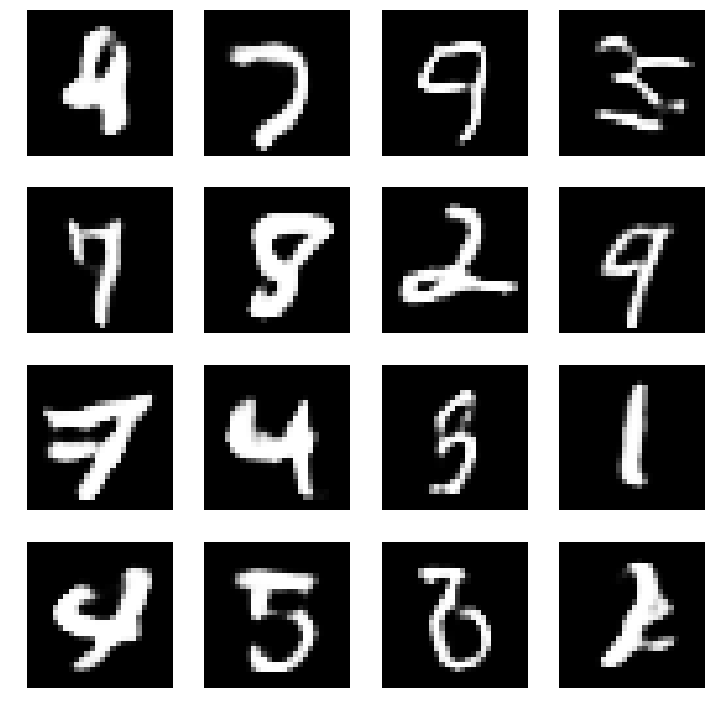

In [6]:
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=500)
timer.elapsed_time()

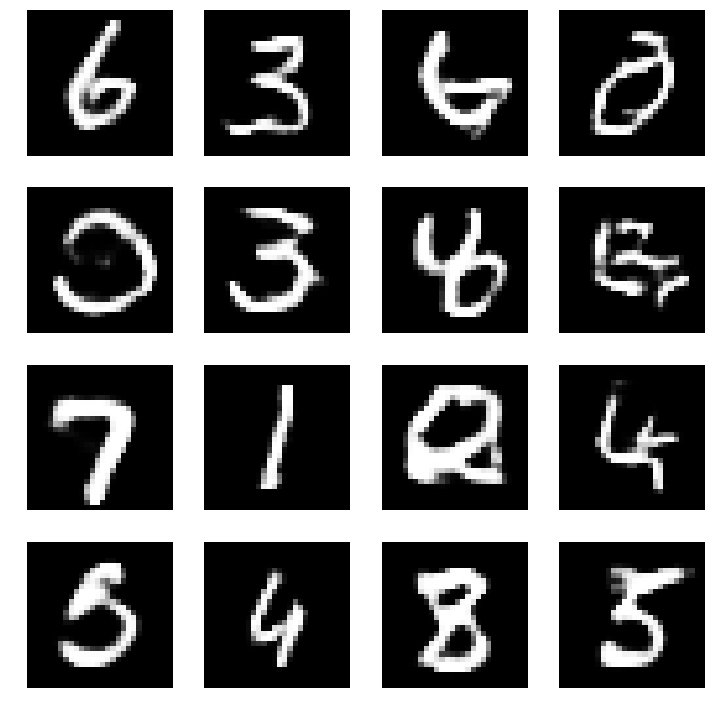

These are all fake numbers generated by our newly trained forger.


In [12]:
mnist_dcgan.plot_images(fake=True)
print('These are all fake numbers generated by our newly trained forger.')

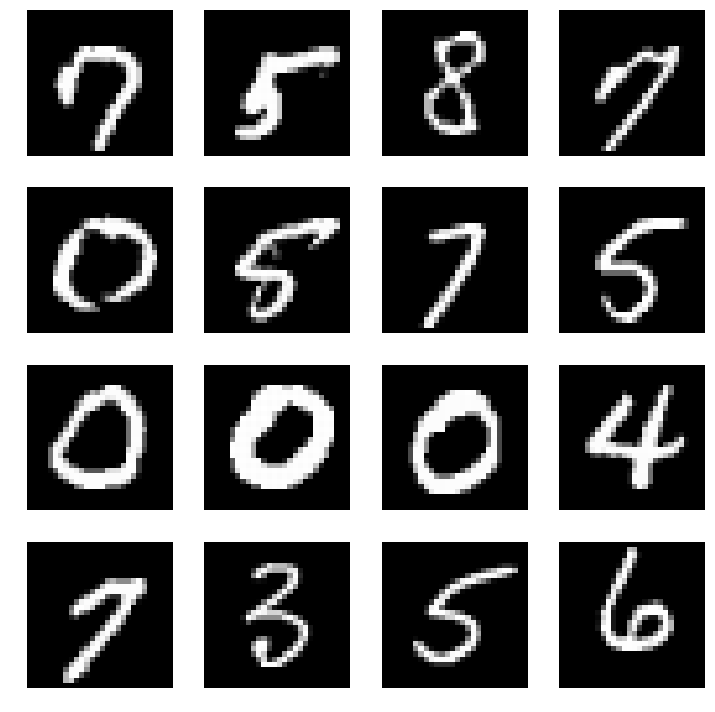

These are real numbers.


In [11]:
mnist_dcgan.plot_images(fake=False)
print('These are real numbers.')